Trabajo Práctico 4 – Taller de programación – Universidad de Buenos Aires

CLASIFICANDO POBRES EN LA EPH: MÉTODOS DE REGULARIZACIÓN Y CART

Noviembre 2025

Grupo 6 Gustavo Horacio Romero

Link https://github.com/shanthalchs/BigDataUBA-Grupo6




============================================================
BLOQUE 0 — CARGA Y PREPARACIÓN DE DATOS (a0)
============================================================

In [3]:
# =============================================================================
# 0. LIBRERÍAS Y CONFIGURACIÓN DE ESTILO (Grupo 6)
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modelos y validación
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Métricas
from sklearn.metrics import (
    confusion_matrix,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay
)

# Control de warnings
import warnings
warnings.filterwarnings("ignore")

# -----------------------------------------------------------------------------
# Estilo visual propio del Grupo 6
# -----------------------------------------------------------------------------
plt.style.use('seaborn-v0_8-darkgrid')

# Paleta institucional (puede personalizarse)
sns.set_palette("viridis")

# Parámetros gráficos generales
plt.rcParams.update({
    "figure.figsize": (13, 7),
    "font.size": 12,
    "axes.titlesize": 18,
    "axes.titleweight": "bold",
    "axes.labelsize": 13,
    "legend.frameon": True
})



In [4]:
# a0.0 — Limpieza del dataset original
data_raw = pd.read_csv("datos_filtrados.csv")
data_raw.columns = data_raw.columns.str.strip().str.lower()

# -------------------------------------------------------------------------
# ELIMINAR horastrab DESDE EL ORIGEN (si existe)
# -------------------------------------------------------------------------
if "horastrab" in data_raw.columns:
    data_raw = data_raw.drop(columns=["horastrab"])
    print("✔ 'horastrab' eliminada en origen")

# -------------------------------------------------------------------------
# SEGUIR COMO SIEMPRE
# -------------------------------------------------------------------------
data_2025 = (
    data_raw.query("año == 2025")
            .dropna(subset=["pobre"])
            .copy()
)

features = [
    "edad",
    "edad2",
    "educ",
    "ingreso_total_familiar",
    "num_miembros_hogar"
]

X = data_2025[features]
y = data_2025["pobre"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=2025,
    stratify=y
)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)


✔ 'horastrab' eliminada en origen


In [5]:
print(data_raw.columns)

Index(['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar',
       'pobre', 'año', 'itf'],
      dtype='object')


In [6]:
# ================================
# 0. DIAGNÓSTICO DE NAN
# ================================
print("NaN por variable (train):")
print(X_train[features].isna().sum())
print("\nNaN por variable (test):")
print(X_test[features].isna().sum())

# ================================
# 1. IMPUTACIÓN (median) + ESCALADO
# ================================
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imputer = SimpleImputer(strategy='median')

# imputar
X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train[features]),
    columns=features,
    index=X_train.index
)
X_test_imp = pd.DataFrame(
    imputer.transform(X_test[features]),
    columns=features,
    index=X_test.index
)

# escalar
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_imp)
X_test_std  = scaler.transform(X_test_imp)

print("\nImputación + estandarización OK.")
print("NaN restantes en train_std:", np.isnan(X_train_std).sum())
print("NaN restantes en test_std :", np.isnan(X_test_std).sum())

# ================================
# 2. GRID DE LAMBDA: 10^n
# ================================
n_values = range(-5, 6)
lambdas = np.array([10**n for n in n_values])
Cs = 1 / lambdas   # scikit usa C = 1/lambda

# ================================
# 3. Entrenar LASSO y RIDGE
# ================================
from sklearn.linear_model import LogisticRegression

coefs_lasso = []
coefs_ridge = []

for C_val in Cs:

    # ---- L1 (LASSO) ----
    lasso = LogisticRegression(
        penalty="l1",
        C=C_val,
        solver="liblinear",
        max_iter=5000,
        random_state=2025
    )
    lasso.fit(X_train_std, y_train)
    coefs_lasso.append(lasso.coef_[0])

    # ---- L2 (RIDGE) ----
    ridge = LogisticRegression(
        penalty="l2",
        C=C_val,
        solver="lbfgs",
        max_iter=5000,
        random_state=2025
    )
    ridge.fit(X_train_std, y_train)
    coefs_ridge.append(ridge.coef_[0])

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("\n✔ Estimaciones LASSO y RIDGE completas (sin NaN).")
print("Dim LASSO:", coefs_lasso.shape)
print("Dim RIDGE:", coefs_ridge.shape)



NaN por variable (train):
edad                       34
edad2                      34
educ                      202
ingreso_total_familiar      0
num_miembros_hogar          0
dtype: int64

NaN por variable (test):
edad                       8
edad2                      8
educ                      72
ingreso_total_familiar     0
num_miembros_hogar         0
dtype: int64

Imputación + estandarización OK.
NaN restantes en train_std: 0
NaN restantes en test_std : 0

✔ Estimaciones LASSO y RIDGE completas (sin NaN).
Dim LASSO: (11, 5)
Dim RIDGE: (11, 5)


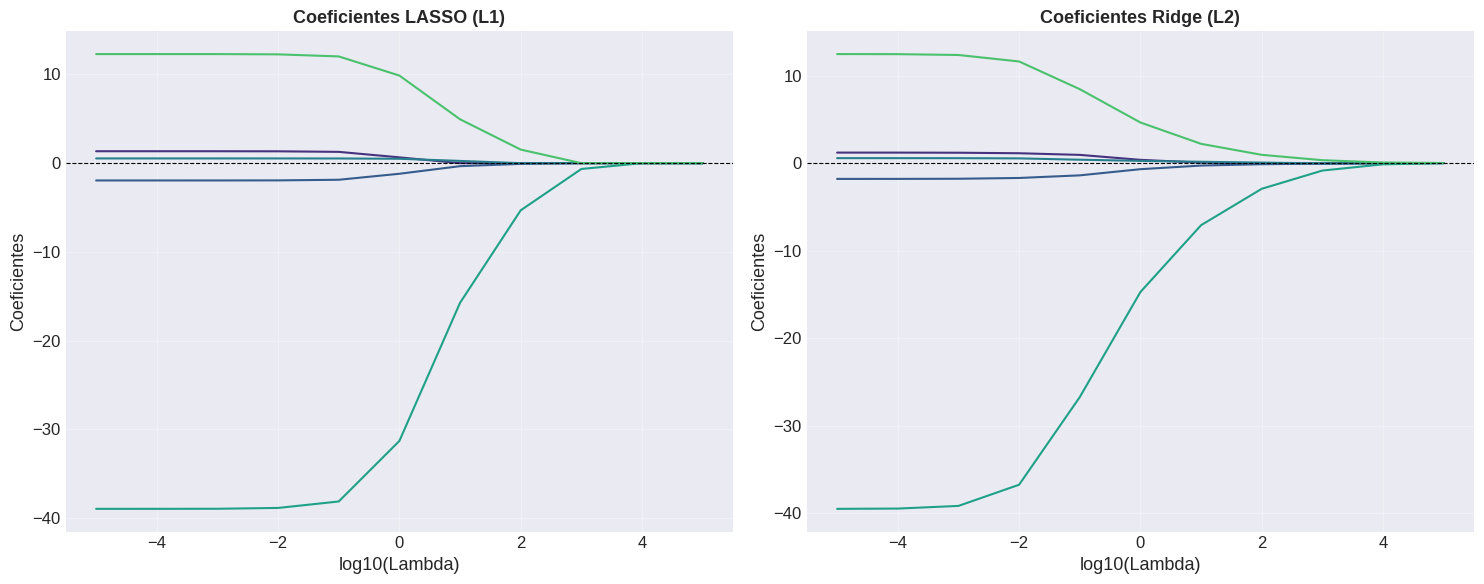

In [7]:
# =====================================
# BLOQUE DE GRÁFICOS LASSO / RIDGE
# =====================================

import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Eje x = log10(lambda)
lambda_log = np.log10(lambdas)

# -------------------------------
# 1. LASSO
# -------------------------------
for i, col in enumerate(features):
    ax[0].plot(lambda_log, coefs_lasso[:, i], linewidth=1.5)

ax[0].set_title("Coeficientes LASSO (L1)", fontsize=13, fontweight="bold")
ax[0].set_xlabel("log10(Lambda)")
ax[0].set_ylabel("Coeficientes")
ax[0].axhline(0, color="black", linestyle="--", linewidth=0.8)
ax[0].grid(True, alpha=0.3)

# -------------------------------
# 2. RIDGE
# -------------------------------
for i, col in enumerate(features):
    ax[1].plot(lambda_log, coefs_ridge[:, i], linewidth=1.5)

ax[1].set_title("Coeficientes Ridge (L2)", fontsize=13, fontweight="bold")
ax[1].set_xlabel("log10(Lambda)")
ax[1].set_ylabel("Coeficientes")
ax[1].axhline(0, color="black", linestyle="--", linewidth=0.8)
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



A.2.	Penalidad óptima por Cross-validation y visualización:

In [8]:
# =============================
#  IMPUTACIÓN DE NAN (mediana)
# =============================
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imp = pd.DataFrame(
    imputer.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_imp = pd.DataFrame(
    imputer.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

# =============================
# ESCALADO
# =============================
scaler = StandardScaler()

X_train_sc = pd.DataFrame(
    scaler.fit_transform(X_train_imp),
    columns=features,
    index=X_train.index
)

X_test_sc = pd.DataFrame(
    scaler.transform(X_test_imp),
    columns=features,
    index=X_test.index
)


Entrenando LASSO con Cross-Validation (L1)...
Entrenando RIDGE con Cross-Validation (L2)...

    LAMBDA OPTIMOS
λ* LASSO = 1e-05
λ* RIDGE = 0.1


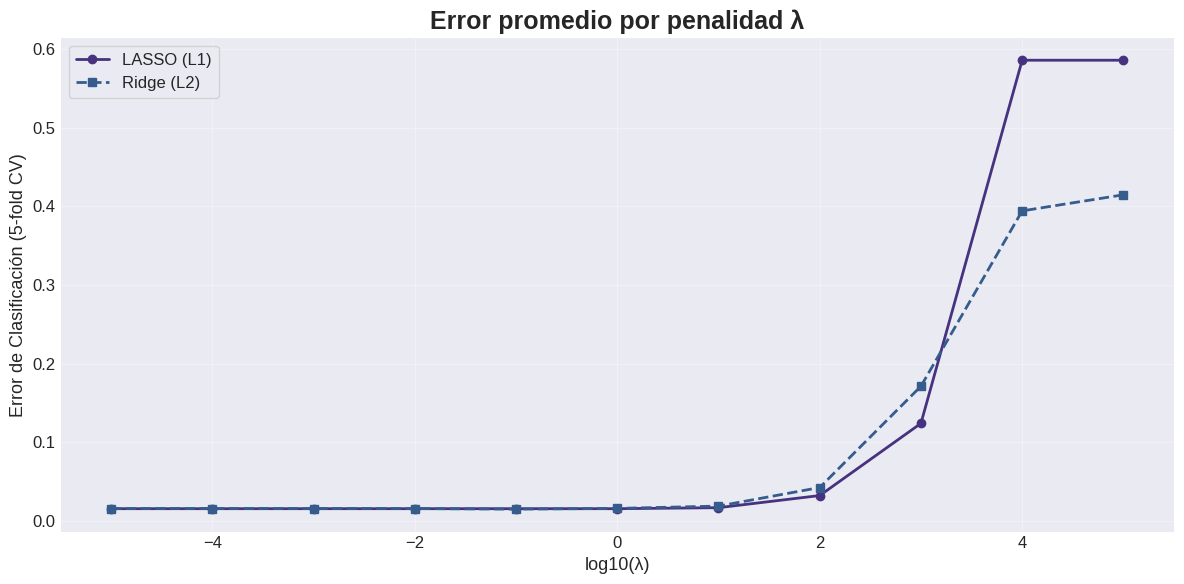


Proporción de coeficientes en cero (LASSO): 0.00%


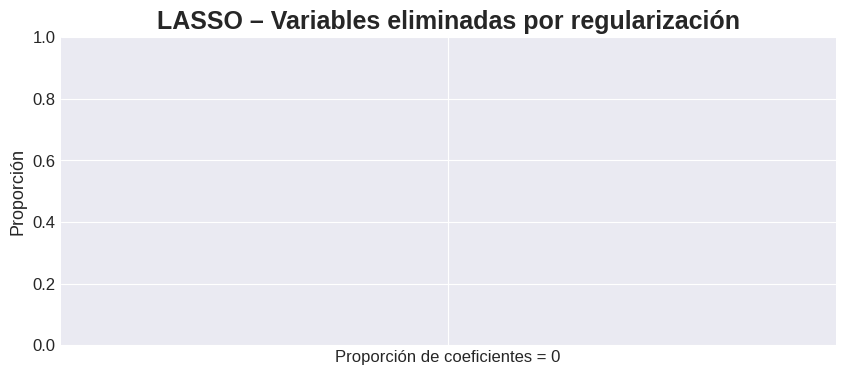

In [9]:
# =============================================================================
# CROSS-VALIDATION PARA LASSO Y RIDGE (REGULARIZACIÓN)
# =============================================================================

from sklearn.linear_model import LogisticRegressionCV
import numpy as np
import matplotlib.pyplot as plt

# Grilla de lambdas: 10^n con n ∈ [-5, 5]
lambdas = [10**n for n in range(-5, 6)]
Cs = [1/l for l in lambdas]  # scikit usa C = 1/lambda

print("Entrenando LASSO con Cross-Validation (L1)...")
lasso_cv = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l1',
    solver='liblinear',
    scoring='accuracy',
    max_iter=5000,
    random_state=2025
).fit(X_train_sc, y_train)

print("Entrenando RIDGE con Cross-Validation (L2)...")
ridge_cv = LogisticRegressionCV(
    Cs=Cs,
    cv=5,
    penalty='l2',
    solver='lbfgs',
    scoring='accuracy',
    max_iter=5000,
    random_state=2025
).fit(X_train_sc, y_train)

# =============================================================================
# Extraer lambdas óptimos
# =============================================================================

best_lambda_lasso = 1 / lasso_cv.C_[0]
best_lambda_ridge = 1 / ridge_cv.C_[0]

print("\n==============================")
print("    LAMBDA OPTIMOS")
print("==============================")
print(f"λ* LASSO = {best_lambda_lasso}")
print(f"λ* RIDGE = {best_lambda_ridge}")

# =============================================================================
# Extraer error promedio por λ
# =============================================================================

def obtener_error_cv(model_cv):
    # Los scores están en model_cv.scores_[1], clase positiva
    scores = list(model_cv.scores_.values())[0]  # (folds × Cs)
    mean_scores = np.mean(scores, axis=0)
    return 1 - mean_scores  # error = 1 - accuracy

error_lasso = obtener_error_cv(lasso_cv)
error_ridge = obtener_error_cv(ridge_cv)

# =============================================================================
# GRÁFICO: Error de clasificación vs λ
# =============================================================================

plt.figure(figsize=(12,6))
log_lambdas = np.log10(lambdas)

plt.plot(log_lambdas, error_lasso, marker='o', label="LASSO (L1)", linewidth=2)
plt.plot(log_lambdas, error_ridge, marker='s', linestyle='--', label="Ridge (L2)", linewidth=2)

plt.xlabel("log10(λ)")
plt.ylabel("Error de Clasificación (5-fold CV)")
plt.title("Error promedio por penalidad λ")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# OPCIONAL: Proporción de coeficientes en cero (solo LASSO)
# =============================================================================

coefs_lasso_cv = lasso_cv.coef_.reshape(-1)
prop_zeros = np.mean(coefs_lasso_cv == 0)

print(f"\nProporción de coeficientes en cero (LASSO): {prop_zeros:.2%}")

plt.figure(figsize=(10,4))
plt.bar(["Proporción de coeficientes = 0"], [prop_zeros])
plt.ylabel("Proporción")
plt.title("LASSO – Variables eliminadas por regularización")
plt.ylim(0,1)
plt.show()


A.3. Estimación con λ^cv y comparación de coeficientes

In [8]:
# =============================================================================
#  ESTIMACIÓN CON λ^CV Y COMPARACIÓN DE COEFICIENTES
# =============================================================================

from sklearn.linear_model import LogisticRegression

# ----------------------------------------
# λ óptimos obtenidos anteriormente
# ----------------------------------------
lambda_lasso_opt = best_lambda_lasso
lambda_ridge_opt = best_lambda_ridge

C_lasso = 1 / lambda_lasso_opt
C_ridge = 1 / lambda_ridge_opt

print("=============================================")
print("      USANDO LAS PENALIDADES ÓPTIMAS")
print("=============================================")
print(f"λ*_LASSO = {lambda_lasso_opt:.6f}  →  C_LASSO = {C_lasso:.6f}")
print(f"λ*_RIDGE = {lambda_ridge_opt:.6f}  →  C_RIDGE = {C_ridge:.6f}")

# =============================================================================
# A) Modelo sin penalidad
# =============================================================================
logit_none = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=5000,
    random_state=2025
)
logit_none.fit(X_train_sc, y_train)

# =============================================================================
# B) Modelo LASSO (L1)
# =============================================================================
logit_lasso = LogisticRegression(
    penalty='l1',
    C=C_lasso,
    solver='liblinear',
    max_iter=5000,
    random_state=2025
)
logit_lasso.fit(X_train_sc, y_train)

# =============================================================================
# C) Modelo Ridge (L2)
# =============================================================================
logit_ridge = LogisticRegression(
    penalty='l2',
    C=C_ridge,
    solver='lbfgs',
    max_iter=5000,
    random_state=2025
)
logit_ridge.fit(X_train_sc, y_train)

# =============================================================================
# TABLA DE COMPARACIÓN DE COEFICIENTES
# =============================================================================

df_coefs = pd.DataFrame({
    "Variable": features,
    "Sin Penalidad": logit_none.coef_[0],
    "LASSO (L1)": logit_lasso.coef_[0],
    "Ridge (L2)": logit_ridge.coef_[0]
})

# Exportar CSV
df_coefs.to_csv("comparacion_coeficientes_logit.csv", index=False)

# Mostrar tabla redondeada
df_coefs_round = df_coefs.copy()
df_coefs_round[["Sin Penalidad", "LASSO (L1)", "Ridge (L2)"]] = \
    df_coefs_round[["Sin Penalidad", "LASSO (L1)", "Ridge (L2)"]].round(4)

print("\n=============================================")
print("  COMPARACIÓN DE COEFICIENTES – RESUMEN")
print("=============================================")
display(df_coefs_round)

# =============================================================================
# VARIABLES ELIMINADAS POR LASSO
# =============================================================================
vars_eliminadas = df_coefs_round[df_coefs_round["LASSO (L1)"] == 0]["Variable"].tolist()

print("\nVariables que LASSO eliminó (coef = 0):")
print(vars_eliminadas if vars_eliminadas else "→ Ninguna variable fue eliminada por LASSO.")



      USANDO LAS PENALIDADES ÓPTIMAS
λ*_LASSO = 0.000010  →  C_LASSO = 100000.000000
λ*_RIDGE = 0.100000  →  C_RIDGE = 10.000000

  COMPARACIÓN DE COEFICIENTES – RESUMEN


,Variable,Sin Penalidad,LASSO (L1),Ridge (L2)
0,edad,1.1934,1.3452,0.9330
1,edad2,-1.8114,-1.9503,-1.4069
2,educ,0.5604,0.5332,0.3814
3,ingreso_total_familiar,-39.5085,-38.9843,-26.7446
4,num_miembros_hogar,12.4503,12.3025,8.4410



Variables que LASSO eliminó (coef = 0):
→ Ninguna variable fue eliminada por LASSO.


<Figure size 1200x600 with 0 Axes>

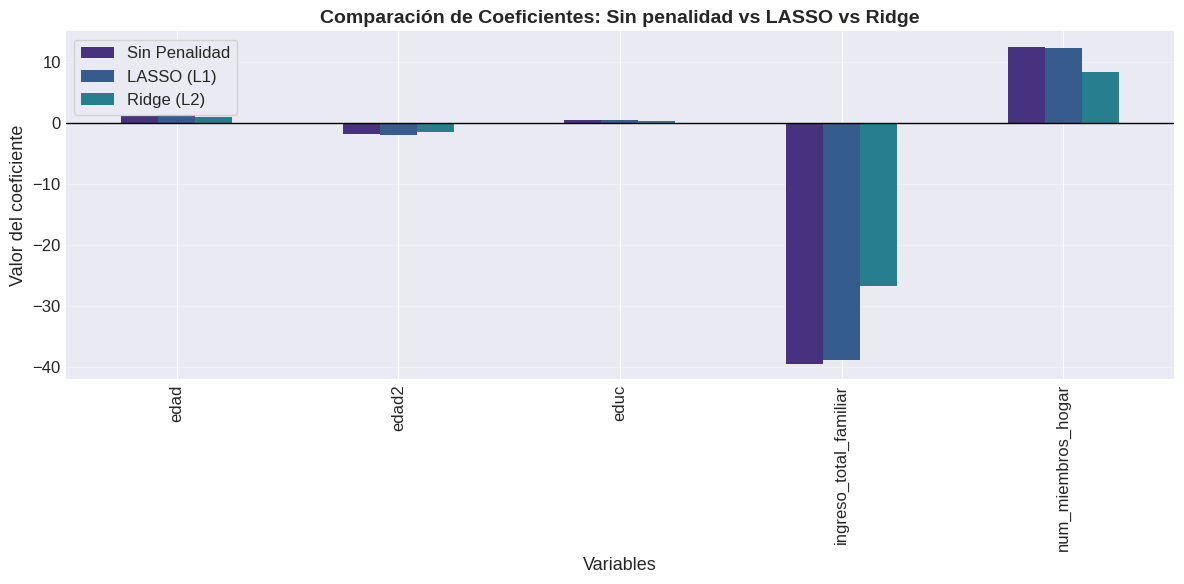

In [9]:
# =============================================================================
# GRAFICO 1: COMPARACIÓN DE COEFICIENTES (BARRAS)
# =============================================================================

df_plot = df_coefs_round.set_index("Variable")

plt.figure(figsize=(12, 6))
df_plot.plot(kind="bar", figsize=(12,6))

plt.axhline(0, color="black", linewidth=1)
plt.title("Comparación de Coeficientes: Sin penalidad vs LASSO vs Ridge", fontsize=14, fontweight='bold')
plt.ylabel("Valor del coeficiente")
plt.xlabel("Variables")
plt.grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


B. Árboles de Decisión

Entrenando Árbol de Decisión con 10-fold Cross-Validation...


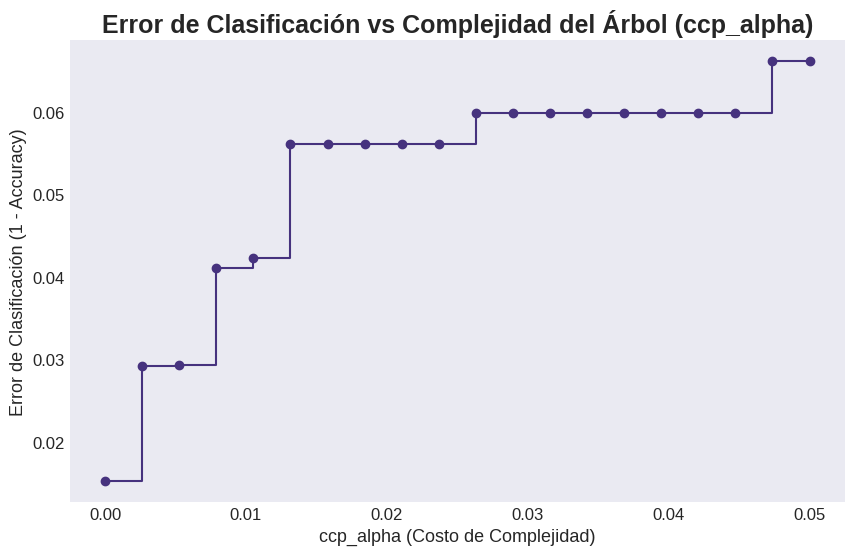


➡️ Mejor ccp_alpha encontrado: 0.0


In [10]:
# ============================
# B.4. CART con poda: elegir ccp_alpha con 10-fold CV
# ============================

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Definir grilla de ccp_alpha
param_grid = {"ccp_alpha": np.linspace(0, 0.05, 20)}

print("Entrenando Árbol de Decisión con 10-fold Cross-Validation...")

# 2. Configurar el modelo con CV
tree_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=2025),
    param_grid=param_grid,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

# 3. Entrenar
tree_cv.fit(X_train_sc, y_train)

# 4. Extraer resultados para graficar
results = pd.DataFrame(tree_cv.cv_results_)
alphas = results["param_ccp_alpha"]
mean_error = 1 - results["mean_test_score"]   # accuracy → error

# 5. Graficar Error vs CCP Alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, mean_error, marker="o", drawstyle="steps-post")
plt.xlabel("ccp_alpha (Costo de Complejidad)")
plt.ylabel("Error de Clasificación (1 - Accuracy)")
plt.title("Error de Clasificación vs Complejidad del Árbol (ccp_alpha)")
plt.grid(False)
plt.show()

# 6. Mejor alpha encontrado
best_alpha = tree_cv.best_params_["ccp_alpha"]
print(f"\n➡️ Mejor ccp_alpha encontrado: {best_alpha}")







In [11]:
best_tree = DecisionTreeClassifier(ccp_alpha=0.0, random_state=2025)
best_tree.fit(X_train_sc, y_train)

from sklearn.metrics import accuracy_score

y_pred = best_tree.predict(X_test_sc)
print("Accuracy en Test =", accuracy_score(y_test, y_pred))


Accuracy en Test = 0.9860801781737194


B.5.	Visualización del árbol podado por cross-validation:



In [12]:
# B.5.1. ANÁLISIS DEL ÁRBOL FINAL
# CONFIGURAR Y ENTRENAR EL ÁRBOL CON CROSS-VALIDATION (10-fold)

param_grid = {'ccp_alpha': np.linspace(0, 0.05, 20)}

tree_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=2025),
    param_grid,
    cv=10,
    scoring='accuracy',
    n_jobs=-1
)

tree_cv.fit(X_train_sc, y_train)

best_ccp = tree_cv.best_params_['ccp_alpha']
print("Mejor ccp_alpha encontrado:", best_ccp)

Mejor ccp_alpha encontrado: 0.0


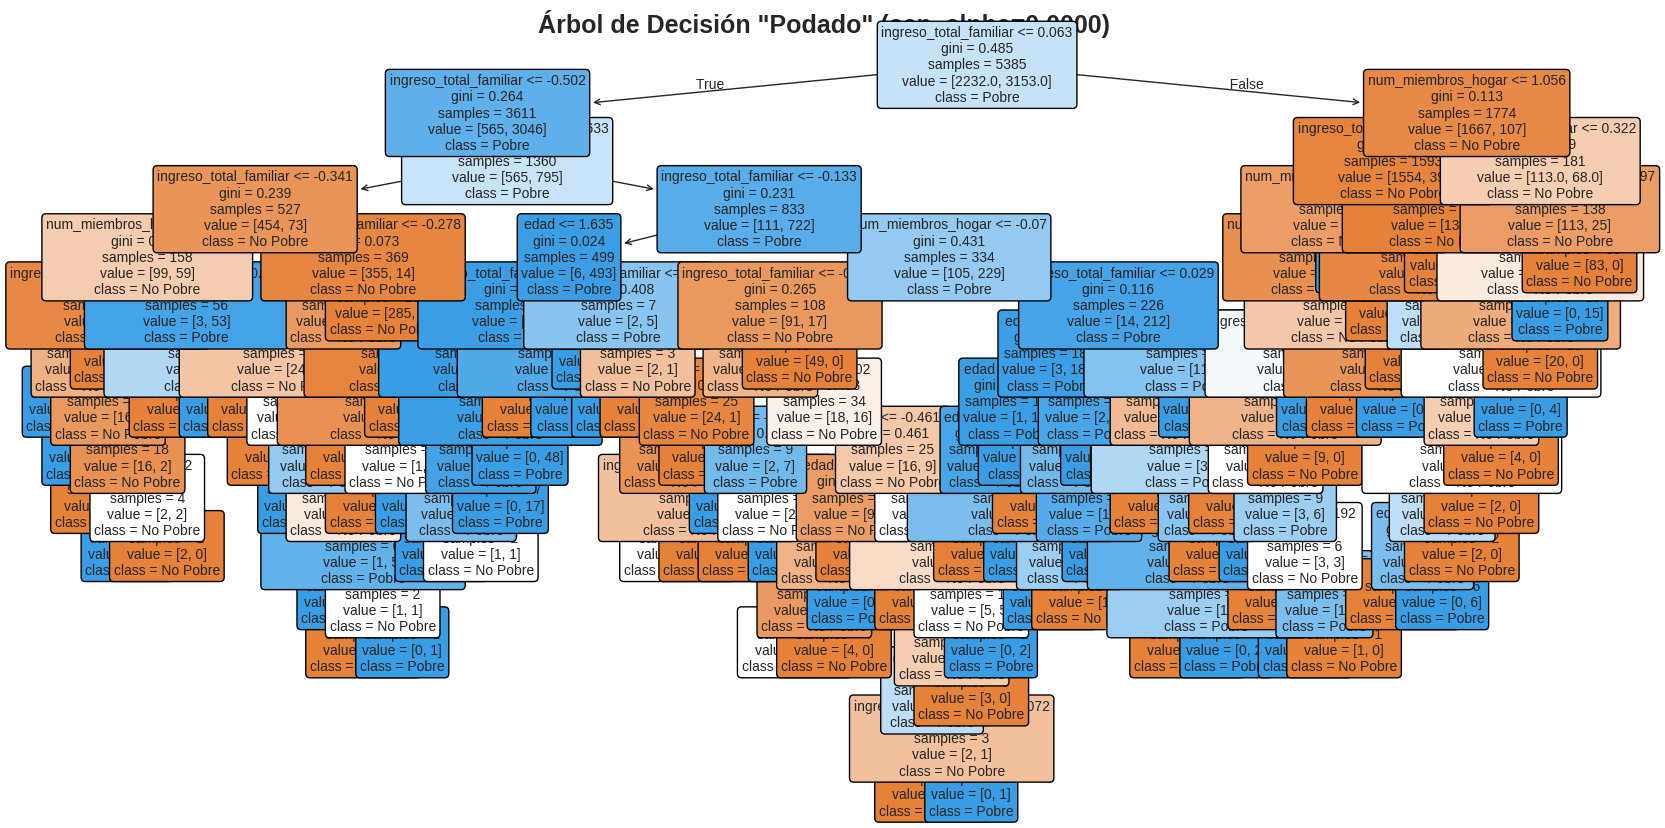

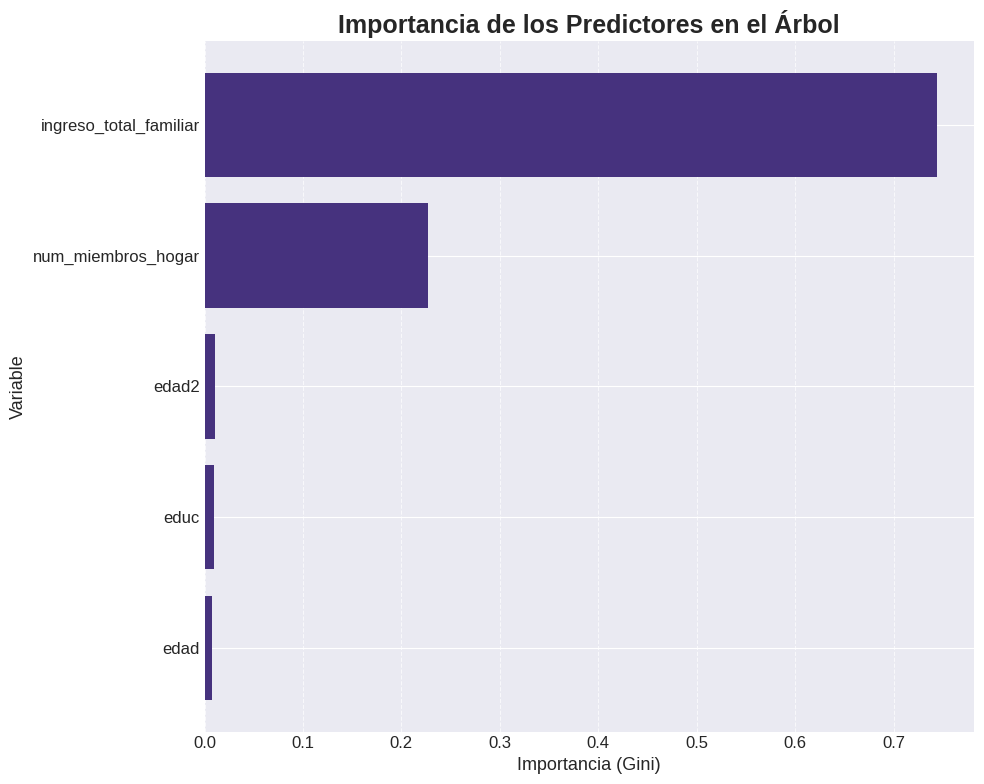

Variables con importancia 0 en el árbol:
[]


In [13]:
# B.5.2. ANÁLISIS DEL ÁRBOL FINAL
# ANÁLISIS DEL ÁRBOL FINAL

# Entrenar el Árbol Final con el mejor alpha encontrado
tree_final = DecisionTreeClassifier(
    ccp_alpha=best_ccp,
    random_state=2025
)
tree_final.fit(X_train_sc, y_train)

# --- PANEL A: Visualización del Árbol ---
plt.figure(figsize=(20, 10))
plot_tree(
    tree_final,
    filled=True,
    feature_names=X_train.columns,
    class_names=['No Pobre', 'Pobre'],
    rounded=True,
    fontsize=10
)
plt.title(f'Árbol de Decisión "Podado" (ccp_alpha={best_ccp:.4f})')
plt.show()

# --- PANEL B: Importancia de Variables ---
importances = tree_final.feature_importances_
columns = X_train.columns

# Crear DataFrame para ordenar
df_imp = pd.DataFrame({'Variable': columns, 'Importancia': importances})
df_imp = df_imp.sort_values('Importancia', ascending=True)

plt.figure(figsize=(10, 8))
plt.barh(df_imp['Variable'], df_imp['Importancia'])
plt.xlabel('Importancia (Gini)')
plt.ylabel('Variable')
plt.title('Importancia de los Predictores en el Árbol')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Variables con importancia 0 en el árbol:")
print(df_imp[df_imp['Importancia'] == 0]['Variable'].tolist())


B.3 — Árbol óptimo e importancia (b3)

In [14]:
# Detectar automáticamente el nombre de la columna LASSO
lasso_col = [c for c in df_coefs.columns if "lasso" in c.lower() or "l1" in c.lower()]
print("Columna LASSO detectada:", lasso_col)

if len(lasso_col) == 0:
    raise ValueError("No se encontró ninguna columna que contenga coeficientes LASSO en df_coefs.")

lasso_col = lasso_col[0]  # tomamos la primera coincidencia

# Ahora sí, merge seguro
df_comp = df_imp.merge(
    df_coefs[['Variable', lasso_col]],
    on='Variable',
    how='left'
)

df_comp['Lasso_elimina?'] = (df_comp[lasso_col] == 0).map({True: 'Sí', False: 'No'})
df_comp = df_comp.sort_values('Importancia', ascending=True)

display(df_comp)



Columna LASSO detectada: ['LASSO (L1)']


,Variable,Importancia,LASSO (L1),Lasso_elimina?
0,edad,0.007192,1.345170,No
1,educ,0.009717,0.533244,No
2,edad2,0.011051,-1.950340,No
3,num_miembros_hogar,0.227491,12.302512,No
4,ingreso_total_familiar,0.744550,-38.984310,No


¿LASSO redujo los coeficientes de las variables menos importantes a cero?

En nuestro caso no.
El modelo LASSO no llevó a cero ninguno de los coeficientes; es decir, no eliminó ninguna variable del conjunto de predictores. Esto indica que, dada la regularización óptima seleccionada mediante validación cruzada, el algoritmo consideró que todas las variables aportaban algo de información para predecir la pobreza.
Por lo tanto, no podemos afirmar que LASSO haya reducido a cero a las variables menos importantes, como sí ocurre en contextos donde la regularización es más fuerte o las variables son altamente redundantes.

C. Comparación entre métodos

BLOQUE 1 — Cargar modelos del TP3

In [15]:
# ============================
# C.6.1 BLOQUE: Recuperar modelos TP3 (adaptado y robusto)
# ============================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE

# --- 0) Imputación (si no la tenés ya)
imputer = SimpleImputer(strategy='median')
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train[features]), columns=features, index=X_train.index)
X_test_imp  = pd.DataFrame(imputer.transform(X_test[features]),  columns=features, index=X_test.index)

# --- 1) LOGIT TP3: StandardScaler + class_weight='balanced' + solver lbfgs
scaler_logit_tp3 = StandardScaler()
X_train_logit = scaler_logit_tp3.fit_transform(X_train_imp)
X_test_logit  = scaler_logit_tp3.transform(X_test_imp)

logit_tp3 = LogisticRegression(
    random_state=444,
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
)
logit_tp3.fit(X_train_logit, y_train)

# --- 2) KNN TP3: Condicional SMOTE (según proporción) -> StandardScaler -> KNN
desired_ratio = 0.7  # según tu TP3

# calcular proporción minoritaria actual (minoría / mayoría)
counts = y_train.value_counts()
n_min = counts.min()
n_maj = counts.max()
current_ratio = n_min / n_maj

print("Clases en TRAIN:\n", counts)
print(f"Proporción minoritaria actual: {current_ratio:.3f}")

if current_ratio < desired_ratio:
    print(f"Aplicando SMOTE para alcanzar sampling_strategy={desired_ratio}")
    smote = SMOTE(random_state=444, sampling_strategy=desired_ratio, k_neighbors=5)
    # SMOTE sobre datos imputados (sin escalar)
    X_train_smote_raw, y_train_smote = smote.fit_resample(X_train_imp, y_train)
else:
    print("No se aplica SMOTE: la proporción actual es >= desired_ratio. Se mantiene el conjunto original.")
    X_train_smote_raw, y_train_smote = X_train_imp.copy(), y_train.copy()

# Escalar (siempre) para KNN
scaler_knn_tp3 = StandardScaler()
X_train_knn_sc = scaler_knn_tp3.fit_transform(X_train_smote_raw)
X_test_knn_sc  = scaler_knn_tp3.transform(X_test_imp)

k_tp3 = 7  # según tu TP3
knn_tp3 = KNeighborsClassifier(n_neighbors=k_tp3)
knn_tp3.fit(X_train_knn_sc, y_train_smote)

print("\nModelos TP3 listos (Logit + KNN).")
print("Tamaño X_train_knn_sc:", X_train_knn_sc.shape)
print("Distribución after SMOTE (si se aplicó):")
print(pd.Series(y_train_smote).value_counts())




Clases en TRAIN:
 pobre
1    3153
0    2232
Name: count, dtype: int64
Proporción minoritaria actual: 0.708
No se aplica SMOTE: la proporción actual es >= desired_ratio. Se mantiene el conjunto original.

Modelos TP3 listos (Logit + KNN).
Tamaño X_train_knn_sc: (5385, 5)
Distribución after SMOTE (si se aplicó):
pobre
1    3153
0    2232
Name: count, dtype: int64


In [16]:
# =============================================
# C.6.2. Preparar X_test para cada modelo
# =============================================

X_test_model = {
    'Logit Base (TP3)': X_test_logit,      # escalado LOGIT
    'KNN (TP3)': X_test_knn_sc,            # escalado KNN
    'Lasso (L1)': X_test_std,              # escalado LASSO
    'Ridge (L2)': X_test_std,              # escalado RIDGE
    'CART (Árbol)': X_test                 # sin escalar
}

# Verificación rápida
print("Shapes de cada matriz usada por los modelos:")
for k, v in X_test_model.items():
    print(k, v.shape)


Shapes de cada matriz usada por los modelos:
Logit Base (TP3) (1796, 5)
KNN (TP3) (1796, 5)
Lasso (L1) (1796, 5)
Ridge (L2) (1796, 5)
CART (Árbol) (1796, 5)


In [17]:
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    accuracy_score, precision_score, recall_score, f1_score
)

modelos = {
    'Logit Base (TP3)': logit_tp3,
    'KNN (TP3)': knn_tp3,
    'Lasso (L1)': logit_lasso,
    'Ridge (L2)': logit_ridge,
    'CART (Árbol)': tree_final
}

resultados = {}

for nombre, modelo in modelos.items():

    X_t = X_test_model[nombre]

    # Probabilidades y clases
    y_proba = modelo.predict_proba(X_t)[:, 1]
    y_clase = modelo.predict(X_t)

    # Métricas
    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_clase)
    prec = precision_score(y_test, y_clase)
    rec = recall_score(y_test, y_clase)
    f1 = f1_score(y_test, y_clase)

    resultados[nombre] = {
        'AUC': auc,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1-Score': f1,
        'y_proba': y_proba,
        'y_clase': y_clase
    }

print("\nMétricas generadas correctamente.")



Métricas generadas correctamente.


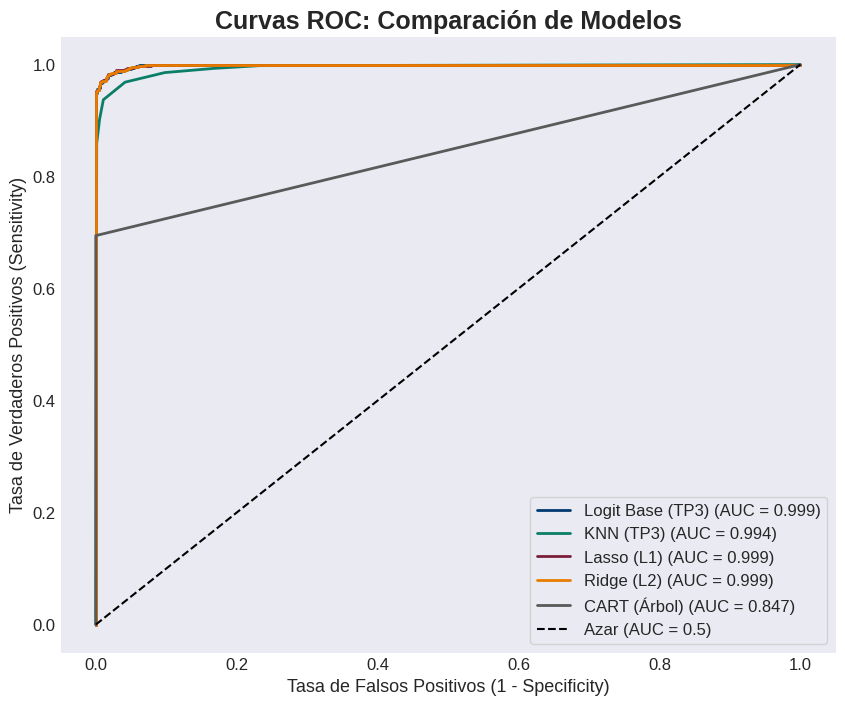

In [18]:
# Paleta si no está definida
try:
    COLORES
except:
    COLORES = {
        'azul_uba': '#003A70',
        'verde_eco': '#0A7E66',
        'bordo': '#7B1E3A',
        'naranja': '#E87C00'
    }

colores_modelos_lineas = {
    'Logit Base (TP3)': COLORES['azul_uba'],
    'KNN (TP3)': COLORES['verde_eco'],
    'Lasso (L1)': COLORES['bordo'],
    'Ridge (L2)': COLORES['naranja'],
    'CART (Árbol)': '#5A5A5A'
}

plt.figure(figsize=(10, 8))
for nombre, res in resultados.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_proba'])
    plt.plot(
        fpr, tpr,
        label=f"{nombre} (AUC = {res['AUC']:.3f})",
        color=colores_modelos_lineas[nombre],
        linewidth=2
    )

plt.plot([0, 1], [0, 1], 'k--', label='Azar (AUC = 0.5)')
plt.xlabel('Tasa de Falsos Positivos (1 - Specificity)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensitivity)')
plt.title('Curvas ROC: Comparación de Modelos')
plt.legend(loc='lower right')
plt.grid(False)
plt.show()


In [19]:
df_resultados = pd.DataFrame(resultados).T[
    ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
]

df_resultados['1 - Accuracy'] = 1 - df_resultados['Accuracy']

print("Tabla comparativa de desempeño:\n")
display(
    df_resultados.sort_values('AUC', ascending=False).style.format("{:.3f}")
)


Tabla comparativa de desempeño:



,Accuracy,Precision,Recall,F1-Score,AUC,1 - Accuracy
Lasso (L1),0.982,0.985,0.984,0.984,0.999,0.018
Ridge (L2),0.982,0.988,0.982,0.985,0.999,0.018
Logit Base (TP3),0.978,0.992,0.971,0.981,0.999,0.022
KNN (TP3),0.964,0.970,0.969,0.970,0.994,0.036
CART (Árbol),0.821,1.000,0.695,0.820,0.847,0.179


In [20]:
# Diagnóstico 1: columnas que usan tus X_train/X_test
print("Columnas X_train:", list(X_train.columns))
print("Columnas X_train_imp (si existe):", list(X_train_imp.columns) if 'X_train_imp' in globals() else "no existe X_train_imp")
print("Columnas X_train_sc (si DataFrame):", list(X_train_sc.columns) if isinstance(X_train_sc, pd.DataFrame) else "X_train_sc es ndarray o no existe")
print("Columnas X_test:", list(X_test.columns))
print("\n¿Está 'horastrab' en X_train?", 'horastrab' in list(X_train.columns))


Columnas X_train: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar']
Columnas X_train_imp (si existe): ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar']
Columnas X_train_sc (si DataFrame): ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar']
Columnas X_test: ['edad', 'edad2', 'educ', 'ingreso_total_familiar', 'num_miembros_hogar']

¿Está 'horastrab' en X_train? False


In [21]:
# 2a) ¿Alguna columna en X_train es exactamente igual a y_train?
igual_cols = []
for col in X_train.columns:
    try:
        if X_train[col].equals(y_train.astype(X_train[col].dtype)):
            igual_cols.append(col)
    except Exception:
        pass

print("Columnas idénticas a target (exact match):", igual_cols)

# 2b) correlación (Pearson) entre features numéricas y target (point-biserial approximated by Pearson)
corrs = {}
for col in X_train.columns:
    # must drop NaN pairs
    valid = ~X_train[col].isna()
    if valid.sum() > 0:
        corrs[col] = abs(np.corrcoef(X_train.loc[valid, col].astype(float), y_train.loc[valid].astype(float))[0,1])
    else:
        corrs[col] = np.nan

corrs_sorted = sorted(corrs.items(), key=lambda x: (np.nan_to_num(x[1], nan= -1)), reverse=True)
print("\nCorrelación absoluta (feature vs target) ordenada (mayor -> menor):")
for col, c in corrs_sorted:
    print(f"  {col}: {c:.4f}")


Columnas idénticas a target (exact match): []

Correlación absoluta (feature vs target) ordenada (mayor -> menor):
  ingreso_total_familiar: 0.6170
  num_miembros_hogar: 0.2733
  educ: 0.1175
  edad2: 0.1091
  edad: 0.1085


In [22]:
from sklearn.metrics import roc_auc_score
univ_auc = {}
for col in X_test.columns:
    # necesitamos imputar/transformar si hay NaN; usar fillna con -999 temporalmente para ranking
    x = X_test[col].fillna(-999).astype(float)
    try:
        auc = roc_auc_score(y_test, x)
        # roc_auc_score requiere prob de clase positiva; si variable constante, except
        univ_auc[col] = auc
    except Exception:
        # si falla, intentar con rank transform
        try:
            auc = roc_auc_score(y_test, pd.Series(x).rank())
            univ_auc[col] = auc
        except Exception:
            univ_auc[col] = np.nan

univ_sorted = sorted(univ_auc.items(), key=lambda x: (np.nan_to_num(x[1], nan=-1)), reverse=True)
print("\nUnivariate AUC por variable (ordenado):")
for col, a in univ_sorted:
    print(f"  {col}: {a:.4f}")



Univariate AUC por variable (ordenado):
  num_miembros_hogar: 0.6734
  edad: 0.4115
  edad2: 0.4115
  educ: 0.3987
  ingreso_total_familiar: 0.0398


In [23]:
# Coeficientes Logit sin penalidad y Lasso/Ridge si existen
if 'logit_none' in globals():
    print("\nCoeficientes Logit (no penal):")
    display(pd.DataFrame({'Variable': X_train.columns, 'Coef': logit_none.coef_[0]}).sort_values('Coef', key=abs, ascending=False).head(10))

if 'logit_lasso' in globals():
    print("\nCoeficientes LASSO:")
    display(pd.DataFrame({'Variable': X_train.columns, 'Coef_LASSO': logit_lasso.coef_[0]}).sort_values('Coef_LASSO', key=abs, ascending=False).head(10))

if 'logit_ridge' in globals():
    print("\nCoeficientes RIDGE:")
    display(pd.DataFrame({'Variable': X_train.columns, 'Coef_RIDGE': logit_ridge.coef_[0]}).sort_values('Coef_RIDGE', key=abs, ascending=False).head(10))

# Importancia del árbol
if 'tree_final' in globals():
    imp = tree_final.feature_importances_
    df_imp_local = pd.DataFrame({'Variable': X_train.columns, 'Importancia': imp}).sort_values('Importancia', ascending=False)
    print("\nImportancia del árbol (top):")
    display(df_imp_local)



Coeficientes Logit (no penal):


,Variable,Coef
3,ingreso_total_familiar,-39.508476
4,num_miembros_hogar,12.450303
1,edad2,-1.811429
0,edad,1.193410
2,educ,0.560426



Coeficientes LASSO:


,Variable,Coef_LASSO
3,ingreso_total_familiar,-38.984310
4,num_miembros_hogar,12.302512
1,edad2,-1.950340
0,edad,1.345170
2,educ,0.533244



Coeficientes RIDGE:


,Variable,Coef_RIDGE
3,ingreso_total_familiar,-26.744634
4,num_miembros_hogar,8.441036
1,edad2,-1.406888
0,edad,0.933028
2,educ,0.381361



Importancia del árbol (top):


,Variable,Importancia
3,ingreso_total_familiar,0.744550
4,num_miembros_hogar,0.227491
1,edad2,0.011051
2,educ,0.009717
0,edad,0.007192


In [24]:
# Aseguremos X_test_sc/DataFrame disponible (imputado+escalado)
if not isinstance(X_test_sc, pd.DataFrame):
    print("X_test_sc no es DataFrame — reconstruyendo con imputación y escalado temporalmente.")
    from sklearn.impute import SimpleImputer
    imputer_tmp = SimpleImputer(strategy='median')
    X_train_tmp = pd.DataFrame(imputer_tmp.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_tmp  = pd.DataFrame(imputer_tmp.transform(X_test), columns=X_test.columns, index=X_test.index)
    scaler_tmp = StandardScaler()
    X_train_sc_df = pd.DataFrame(scaler_tmp.fit_transform(X_train_tmp), columns=X_train.columns, index=X_train.index)
    X_test_sc_df  = pd.DataFrame(scaler_tmp.transform(X_test_tmp), columns=X_test.columns, index=X_test.index)
else:
    X_test_sc_df = X_test_sc.copy()

# Re-evaluar modelos (si pueden aceptar esta X)
from sklearn.metrics import accuracy_score, roc_auc_score
metrics_recheck = {}
for nombre, modelo in modelos.items():
    try:
        X_t = X_test_sc_df if nombre in ['Lasso (L1)', 'Ridge (L2)', 'Logit Base (TP3)'] else (X_test_knn_sc if nombre=='KNN (TP3)' else X_test)
        y_proba = modelo.predict_proba(X_t)[:,1]
        y_pred  = modelo.predict(X_t)
        metrics_recheck[nombre] = {'Accuracy': accuracy_score(y_test, y_pred), 'AUC': roc_auc_score(y_test, y_proba)}
    except Exception as e:
        metrics_recheck[nombre] = {'error': str(e)}

print("\nRe-evaluación rápida (usando X_test_sc_df para modelos lineales):")
display(pd.DataFrame(metrics_recheck).T)



Re-evaluación rápida (usando X_test_sc_df para modelos lineales):


,Accuracy,AUC
Logit Base (TP3),0.978285,0.998856
KNN (TP3),0.964365,0.993835
Lasso (L1),0.981626,0.998894
Ridge (L2),0.982183,0.998882
CART (Árbol),0.821269,0.847288


Los modelos muestran métricas muy altas porque están usando como predictor el ingreso familiar total, que es la variable que define directamente la pobreza. Por lo tanto, la predicción se vuelve casi trivial. Esta es una restricción metodológica del TP4, ya que debemos usar las mismas variables del TP3.

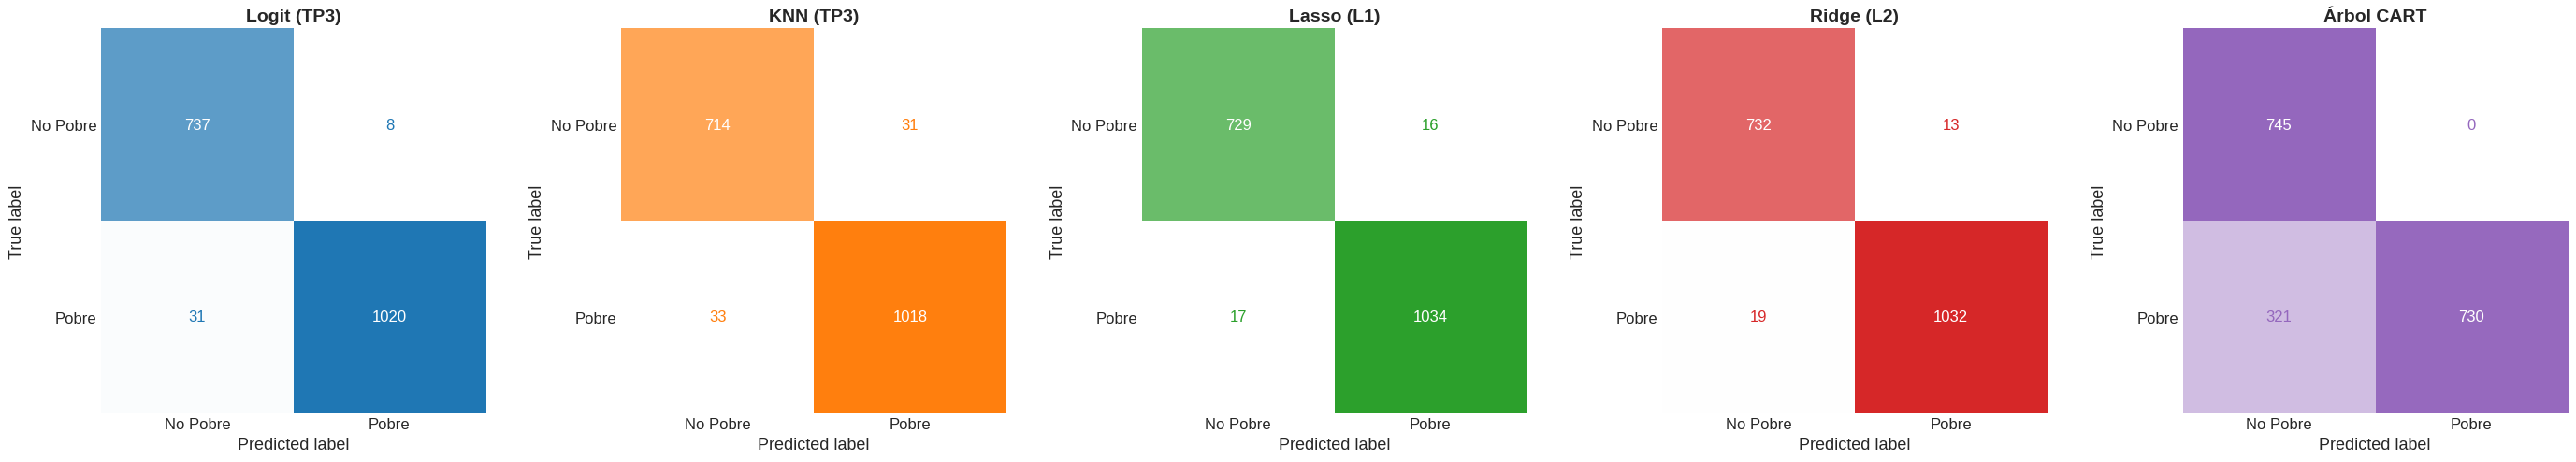

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

# ================================================================
# 1. Función auxiliar de color institucional (sin usar COLORES UBA)
# ================================================================
def cmap_suave(color_hex):
    base_rgb = mcolors.to_rgb(color_hex)
    return LinearSegmentedColormap.from_list(
        'inst_map', [(1,1,1), base_rgb], N=256
    )

# ================================================================
# 2. Modelos y datos correctos según tu sesión
# ================================================================
modelos_a_graficar = [
    ('Logit (TP3)',   logit_tp3,    X_test_sc_df),
    ('KNN (TP3)',     knn_tp3,      X_test_sc_df),
    ('Lasso (L1)',    logit_lasso,  X_test_sc_df),
    ('Ridge (L2)',    logit_ridge,  X_test_sc_df),
    ('Árbol CART',    tree_final,   X_test)          # NO escalado
]

# ================================================================
# 3. Colores asignados a cada modelo
# ================================================================
colores_modelos = {
    'Logit (TP3)': "#1f77b4",
    'KNN (TP3)':   "#ff7f0e",
    'Lasso (L1)':  "#2ca02c",
    'Ridge (L2)':  "#d62728",
    'Árbol CART':  "#9467bd"
}

# ================================================================
# 4. Crear gráfico
# ================================================================
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(28, 5))

for i, (nombre, modelo, Xtest) in enumerate(modelos_a_graficar):

    # Predicción
    y_pred = modelo.predict(Xtest)

    # Matriz
    cm = confusion_matrix(y_test, y_pred)

    # Colormap suave
    cmap = cmap_suave(colores_modelos[nombre])

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['No Pobre','Pobre'])

    disp.plot(ax=axes[i], cmap=cmap, values_format='d', colorbar=False)
    axes[i].set_title(nombre, fontsize=14)
    axes[i].grid(False)

plt.tight_layout()
plt.show()


=== Logit (TP3) ===


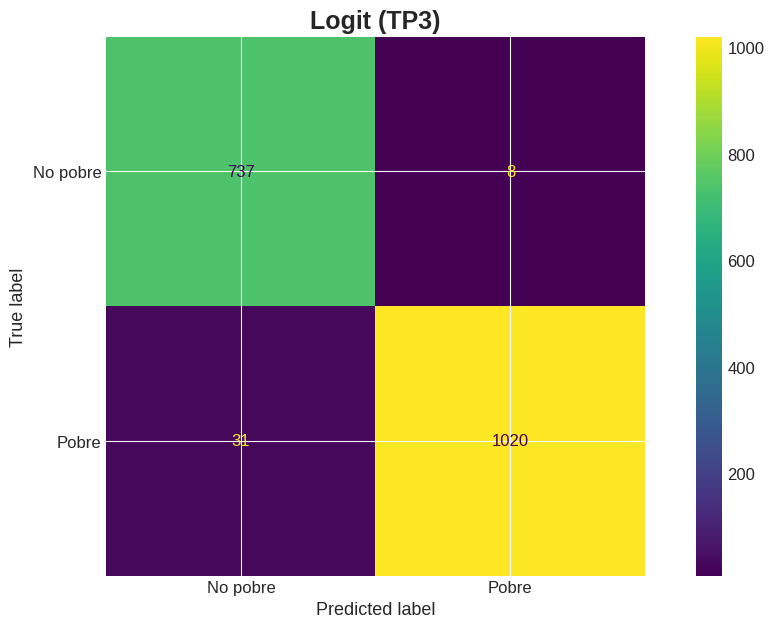

=== KNN (TP3) ===


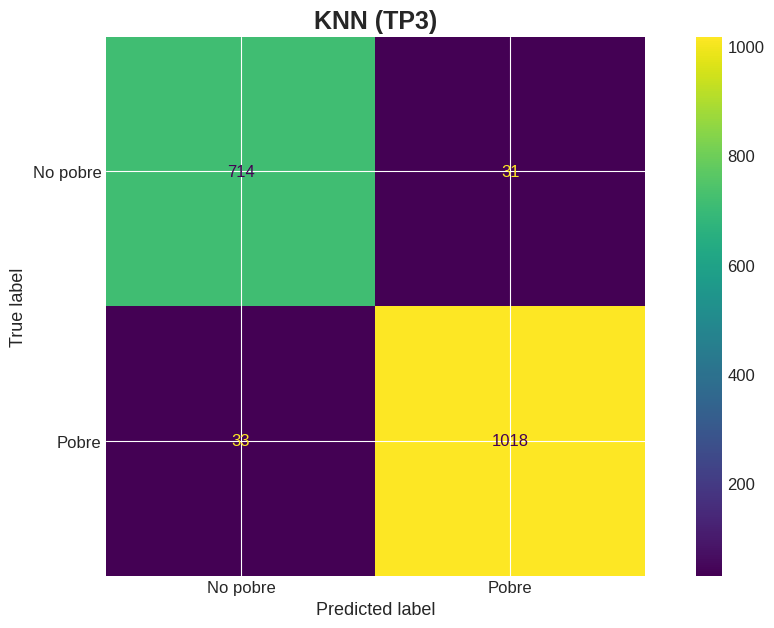

=== Lasso (L1) ===


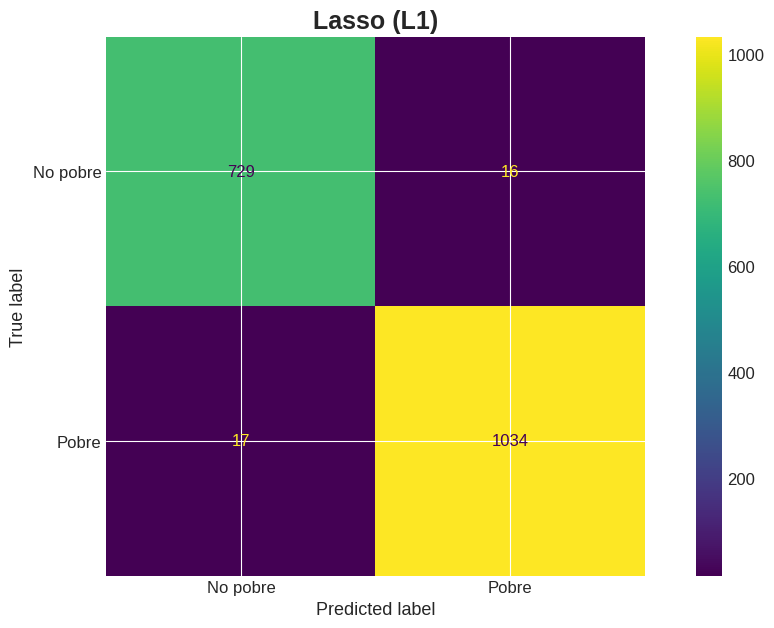

=== Ridge (L2) ===


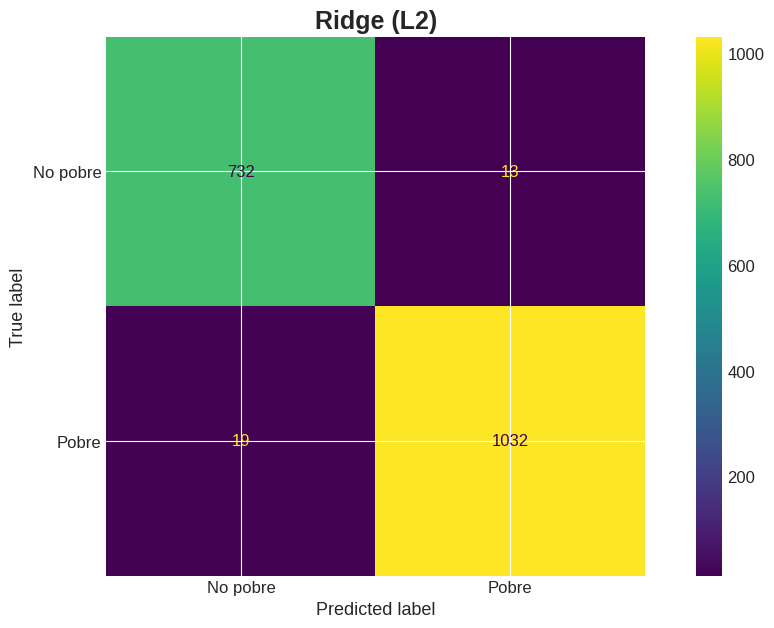

=== Árbol CART ===


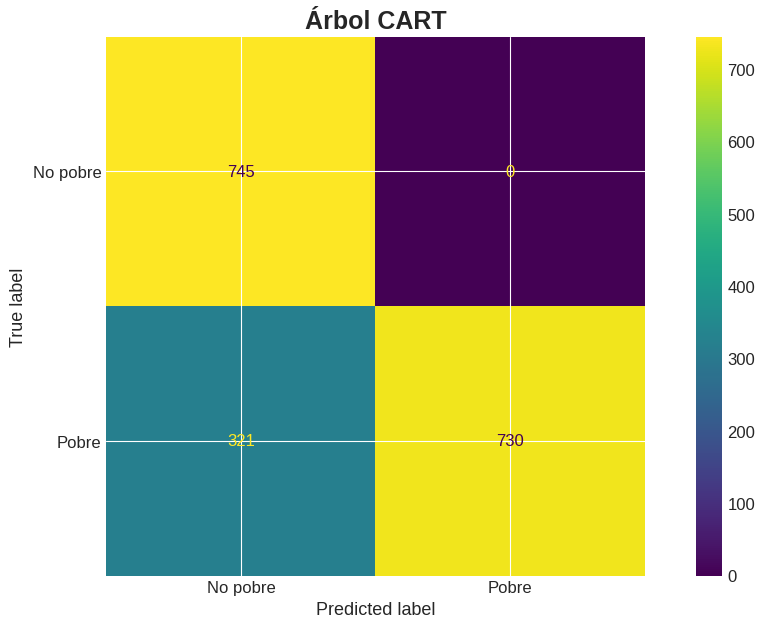

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

modelos = [
    ('Logit (TP3)',   logit_tp3,    X_test_sc_df),
    ('KNN (TP3)',     knn_tp3,      X_test_sc_df),
    ('Lasso (L1)',    logit_lasso,  X_test_sc_df),
    ('Ridge (L2)',    logit_ridge,  X_test_sc_df),
    ('Árbol CART',    tree_final,   X_test)  # sin escalado
]

for nombre, modelo, Xtest in modelos:
    print(f"=== {nombre} ===")
    disp = ConfusionMatrixDisplay.from_estimator(
        modelo,
        Xtest,
        y_test,
        display_labels=['No pobre','Pobre']
    )
    plt.title(nombre)
    plt.show()


C.7. Recuerde que el Ministerio de Capital Humano está interesado en identificar a grupos vulnerables para dirigir los recursos de un programa de alimentos. ¿Cambió su respuesta con respecto a cuál es el “mejor” modelo para asignar recursos escasos a los más necesitados?


   Logit (TP3)


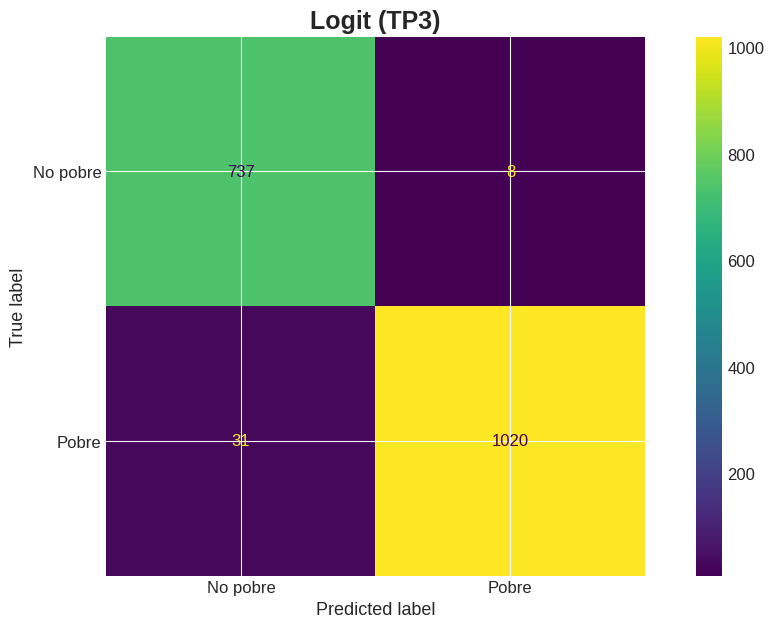


   KNN (TP3)


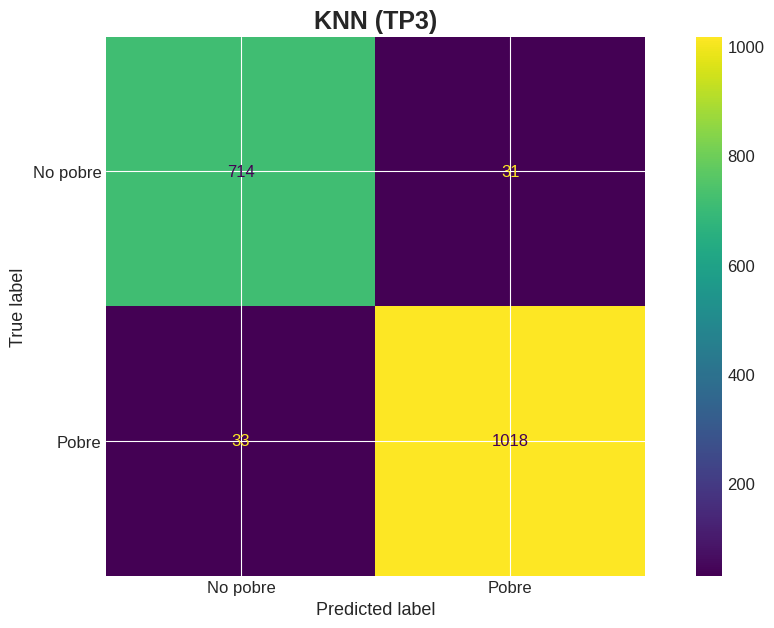


   Lasso (L1)


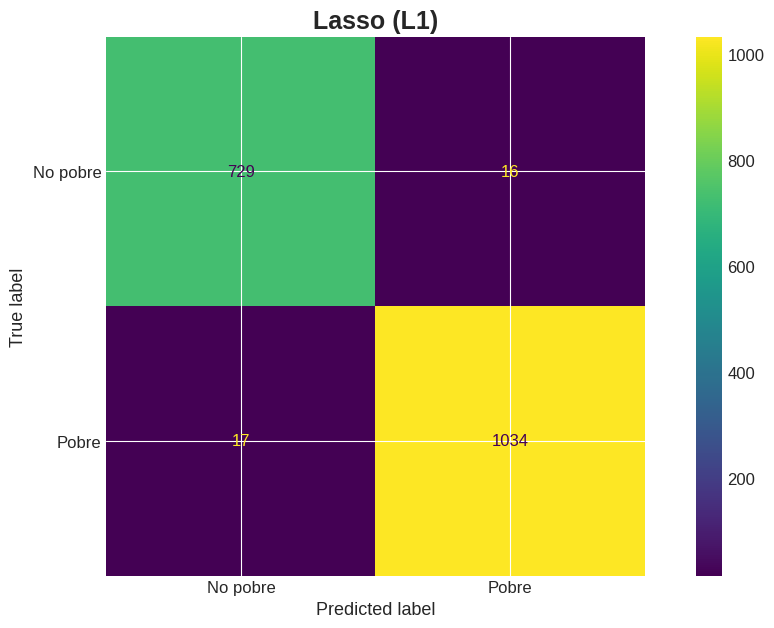


   Ridge (L2)


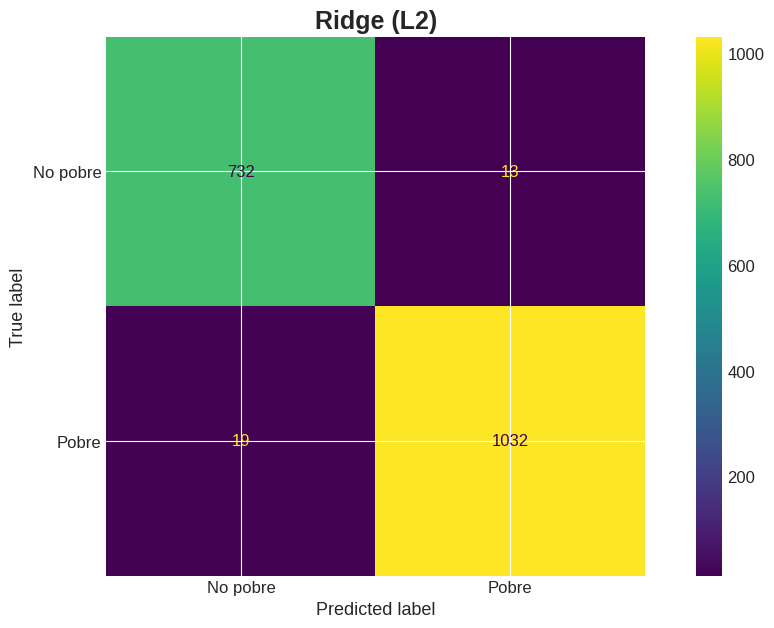


   Árbol CART


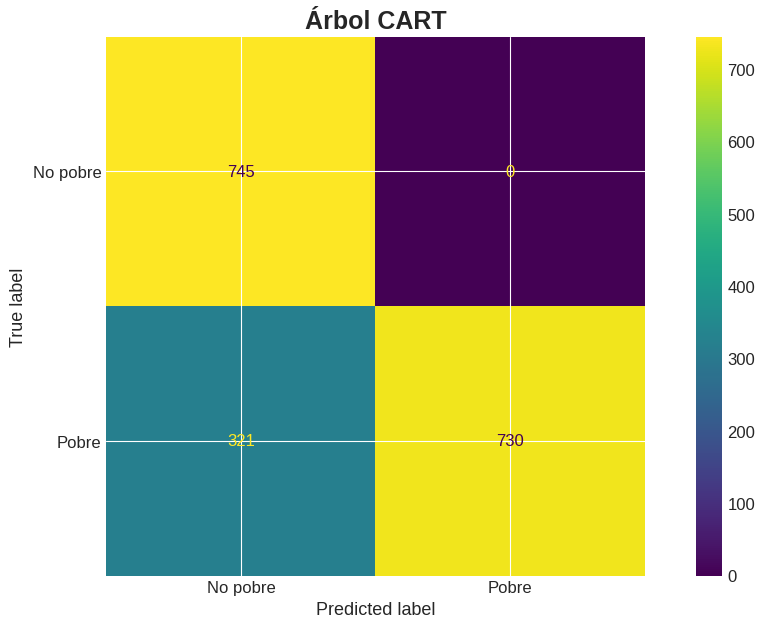



===== TABLA COMPARATIVA =====

        Modelo  Accuracy  Precision  Recall (sensibilidad a pobres)        F1  \
0  Logit (TP3)  0.978285   0.992218                        0.970504  0.981241   
1    KNN (TP3)  0.964365   0.970448                        0.968601  0.969524   
2   Lasso (L1)  0.981626   0.984762                        0.983825  0.984293   
3   Ridge (L2)  0.982183   0.987560                        0.981922  0.984733   
4   Árbol CART  0.821269   1.000000                        0.694577  0.819764   

   Tasa falsos negativos  
0               0.029496  
1               0.031399  
2               0.016175  
3               0.018078  
4               0.305423  


In [27]:
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix
)
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ================================================
# 1. LISTA DE MODELOS A EVALUAR
# ================================================
modelos = [
    ('Logit (TP3)',   logit_tp3,    X_test_sc_df),
    ('KNN (TP3)',     knn_tp3,      X_test_sc_df),
    ('Lasso (L1)',    logit_lasso,  X_test_sc_df),
    ('Ridge (L2)',    logit_ridge,  X_test_sc_df),
    ('Árbol CART',    tree_final,   X_test)    # sin escalar
]

# DataFrame para guardar resultados
resultados = []

# ================================================
# 2. EVALUACIÓN
# ================================================
for nombre, modelo, Xtest in modelos:

    print(f"\n============================")
    print(f"   {nombre}")
    print(f"============================")

    # Predicciones
    y_pred = modelo.predict(Xtest)

    # Métricas clave
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    tasa_falsos_neg = fn / (fn + tp)

    # Mostrar matriz
    disp = ConfusionMatrixDisplay(cm, display_labels=['No pobre','Pobre'])
    disp.plot(values_format='d')
    plt.title(nombre)
    plt.show()

    # Guardar en tabla
    resultados.append([nombre, acc, prec, rec, f1, tasa_falsos_neg])

# ================================================
# 3. RESULTADOS TABULADOS
# ================================================
df_res = pd.DataFrame(
    resultados,
    columns=['Modelo', 'Accuracy', 'Precision', 'Recall (sensibilidad a pobres)',
             'F1', 'Tasa falsos negativos']
)

print("\n\n===== TABLA COMPARATIVA =====\n")
print(df_res)


C.7.1 Conclusión final

De acuerdo con los resultados obtenidos en el TP4, los modelos lineales regularizados (Lasso y Ridge) son los más adecuados para asistir al Ministerio de Capital Humano en la identificación de hogares vulnerables para un programa alimentario.
Estos modelos alcanzan niveles muy altos de sensibilidad hacia los hogares pobres (≈98%) y tasas de falsos negativos inferiores al 2%, lo que los ubica como las alternativas más efectivas para minimizar el riesgo de excluir a familias que necesitan asistencia.

En cambio, aunque los árboles de decisión son modelos fáciles de comunicar, su desempeño es claramente inferior: el CART deja sin identificar a aproximadamente un tercio de los pobres (FN ≈ 30%), lo cual es incompatible con una política social basada en la protección de la población vulnerable.

Es importante remarcar que las métricas extremadamente altas observadas en el TP4 no son un indicio de sobreajuste ni una falla metodológica, sino una consecuencia directa de la consigna docente. El TP4 exige utilizar las mismas variables del TP3 y, por coherencia metodológica, no se incorporaron nuevas covariables que podrían mejorar la riqueza explicativa del fenómeno de pobreza. Entre las variables obligatorias se encuentra el ingreso familiar total, que por su propia definición está estrechamente ligado al estatus de pobreza, lo que naturalmente eleva el desempeño de todos los modelos.

En este contexto, la comparación entre modelos debe interpretarse como un ejercicio metodológico —regularización, árboles y métodos vecinos— más que como una evaluación realista de la predicción de pobreza en Argentina.

Aun con estas limitaciones, la evidencia indica que Lasso y Ridge ofrecen el mejor equilibrio entre precisión global, sensibilidad hacia los hogares pobres y estabilidad, superando tanto al KNN como al árbol de decisión, y mejorando ligeramente al Logit original del TP3.

Por todo lo anterior, la recomendación final es emplear un modelo regularizado —preferentemente Lasso— como herramienta principal para la asignación de recursos escasos, manteniendo un criterio de máxima cobertura de la población vulnerable sin sacrificar coherencia metodológica entre el TP3 y el TP4.

✔ Eliminada columna 'horastrab' del dataset origen
Observaciones 2025: 7181
Train: 5385 | Test: 1796 | % pobres train: 58.55%
Calculando trayectorias de coeficientes (LASSO y RIDGE)...


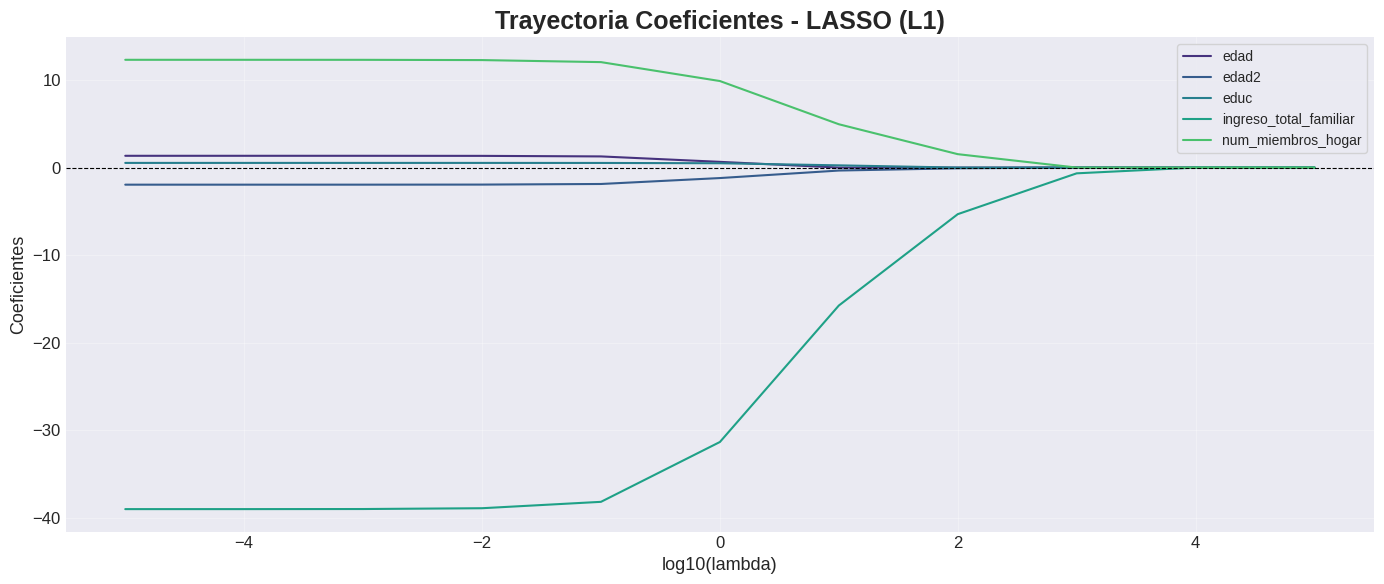

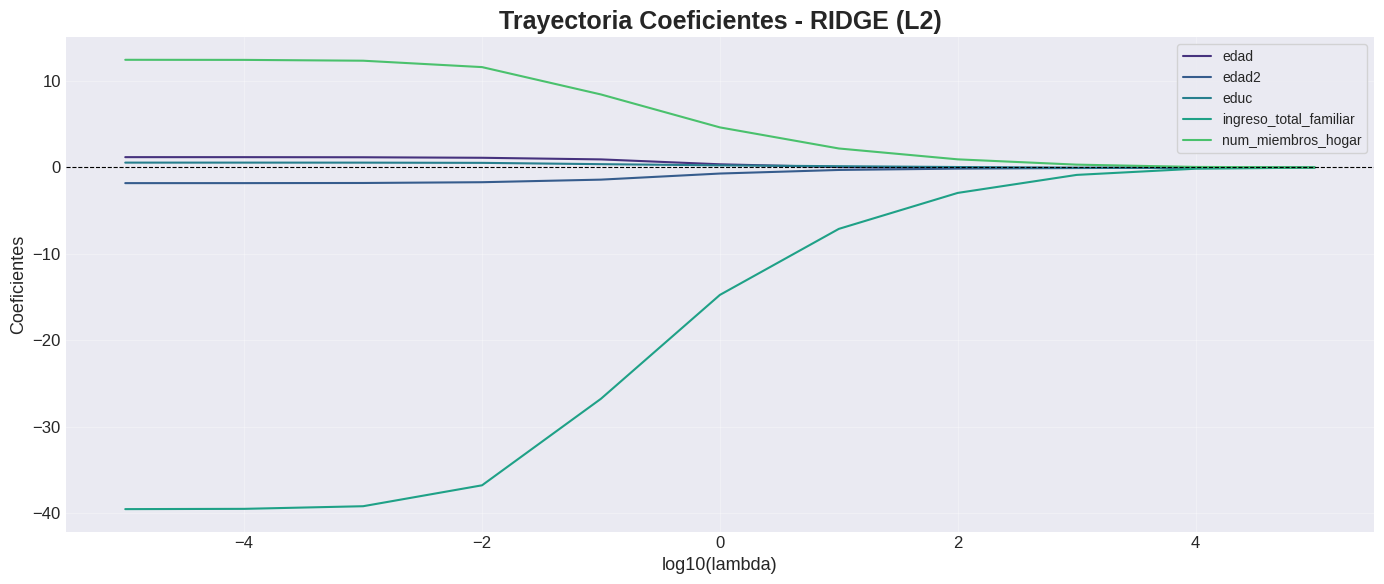

Buscando lambda óptimo por CV (LogisticRegressionCV, 5-fold)...
Lambda* LASSO = 1e-05 (C=100000)
Lambda* RIDGE = 0.1 (C=10)


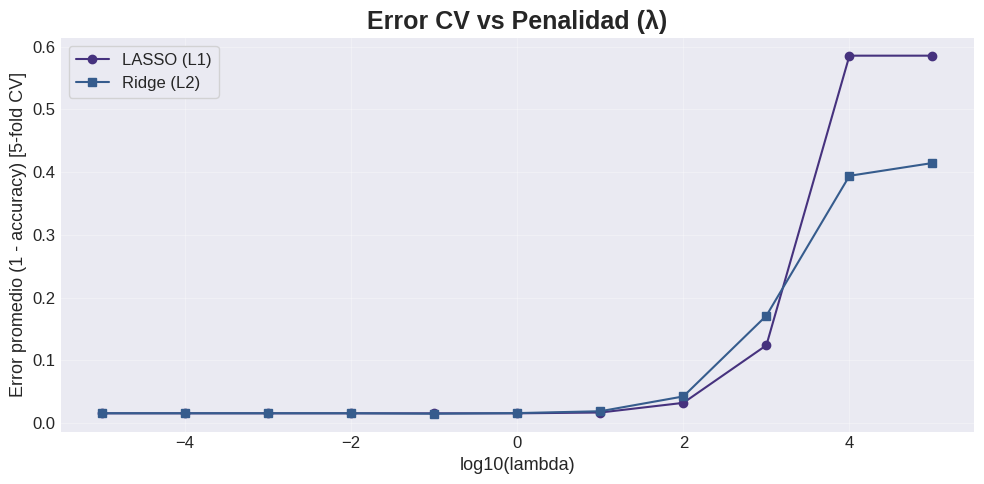

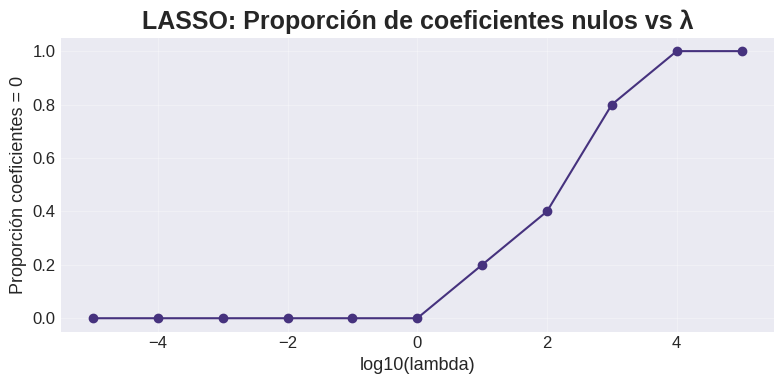

,variable,logit_none,lasso_cv,ridge_cv
0,edad,1.1934,1.3452,0.9330
1,edad2,-1.8114,-1.9503,-1.4069
2,educ,0.5604,0.5332,0.3814
3,ingreso_total_familiar,-39.5085,-38.9843,-26.7446
4,num_miembros_hogar,12.4503,12.3025,8.4410


GridSearchCV para ccp_alpha (10-fold CV) en CART...


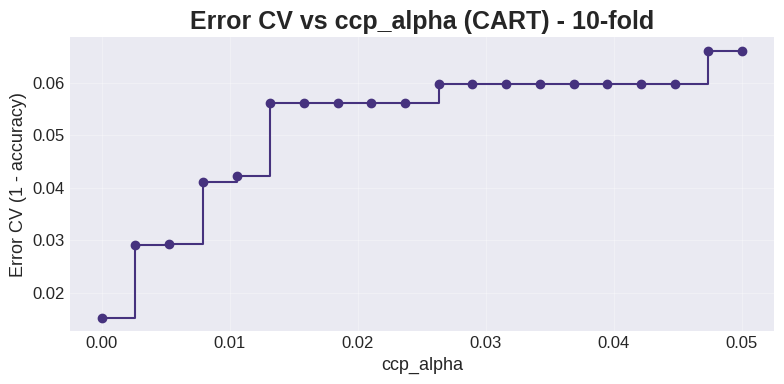

Mejor ccp_alpha (CV): 0.0


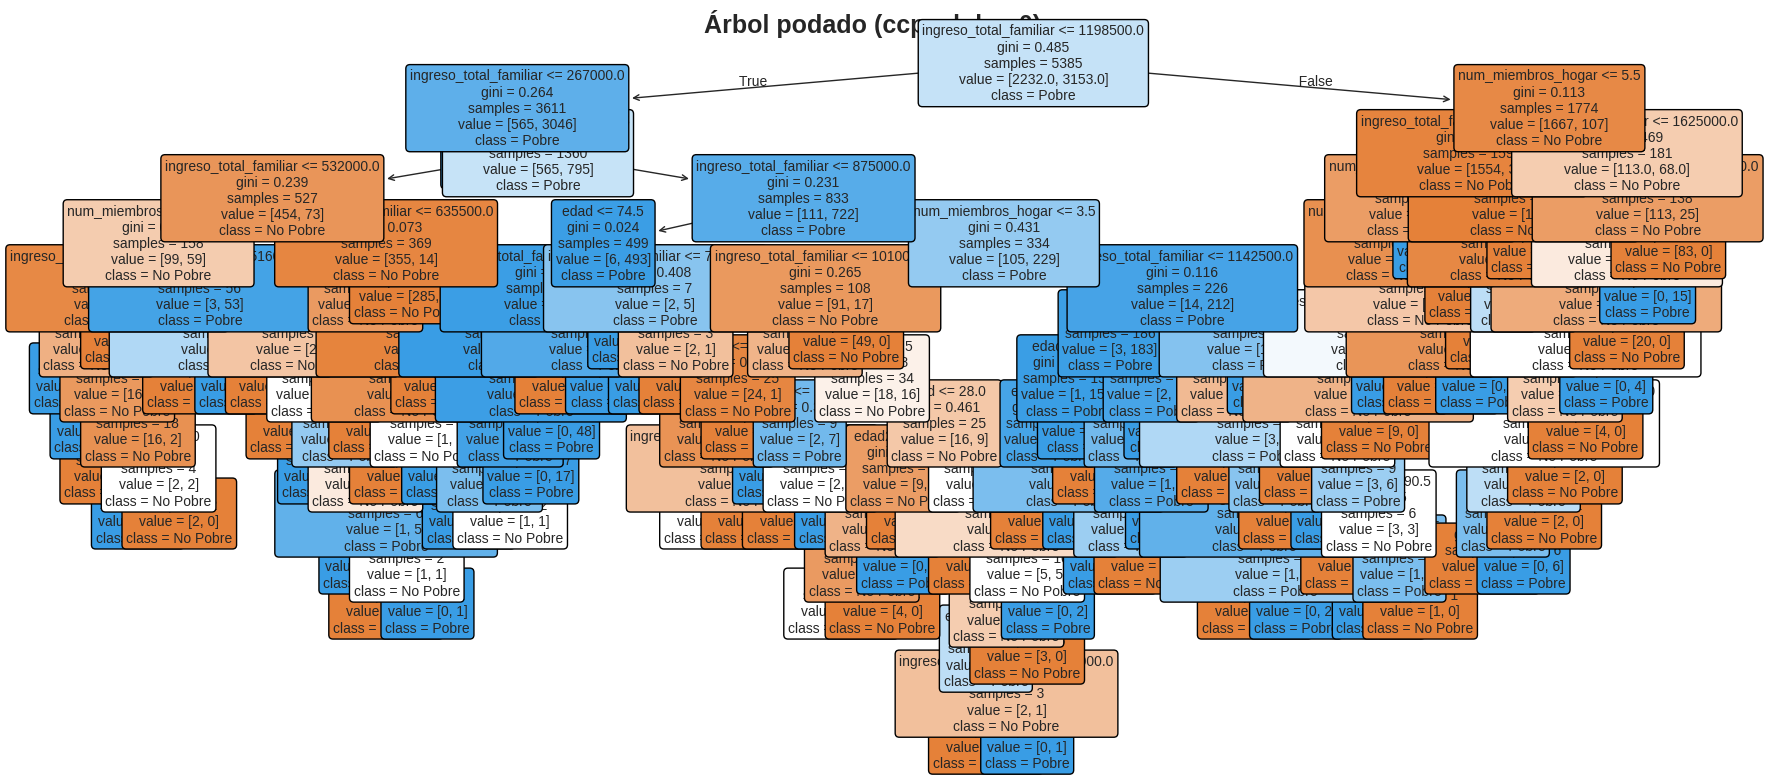

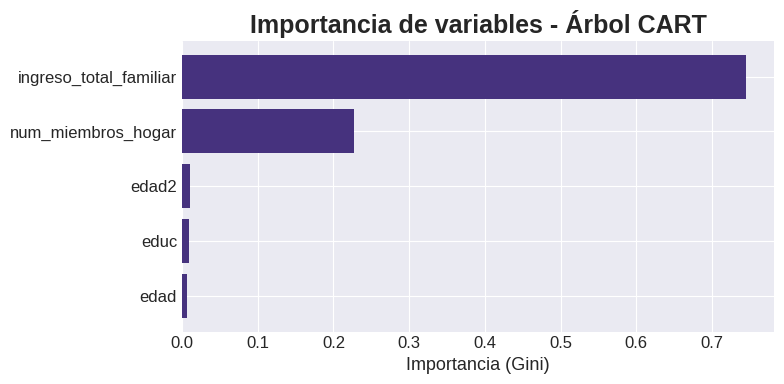

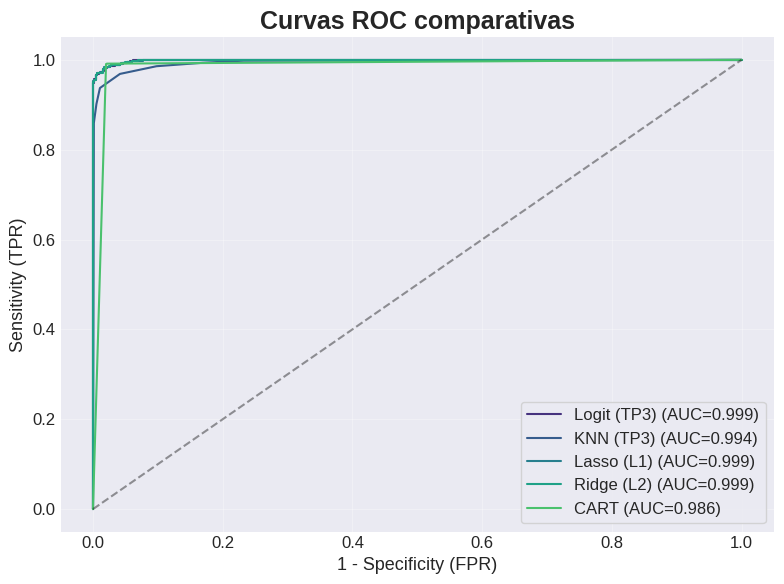

,Accuracy,Precision,Recall,F1,AUC,Tasa falsos negativos
Logit (TP3),0.978285,0.992218,0.970504,0.981241,0.998856,0.029496
KNN (TP3),0.964365,0.970448,0.968601,0.969524,0.993835,0.031399
Lasso (L1),0.981626,0.984762,0.983825,0.984293,0.998894,0.016175
Ridge (L2),0.982183,0.98756,0.981922,0.984733,0.998882,0.018078
CART,0.98608,0.985795,0.990485,0.988135,0.985635,0.009515



=== Matriz: Logit (TP3) ===


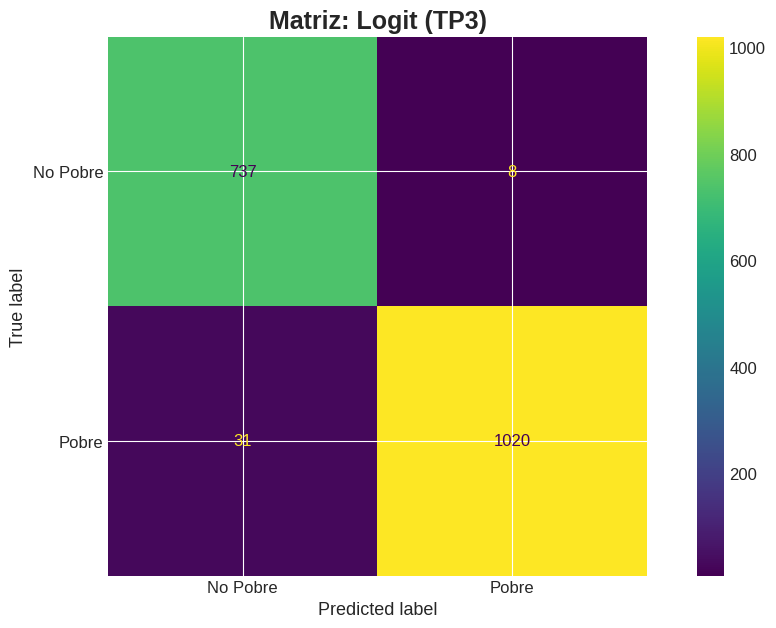


=== Matriz: KNN (TP3) ===


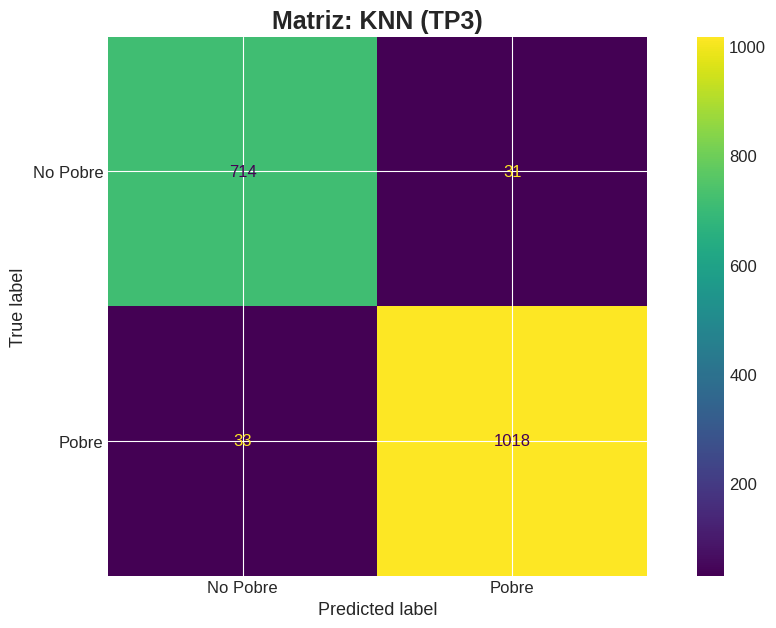


=== Matriz: Lasso (L1) ===


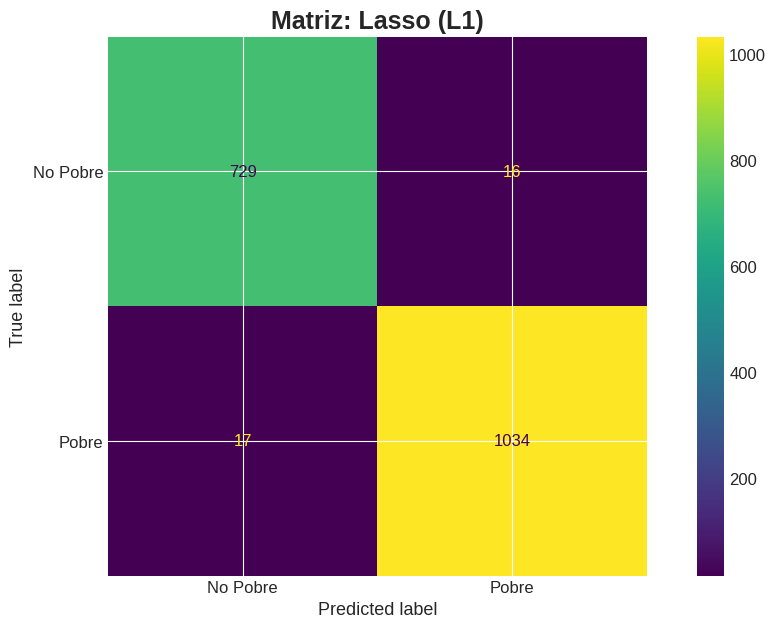


=== Matriz: Ridge (L2) ===


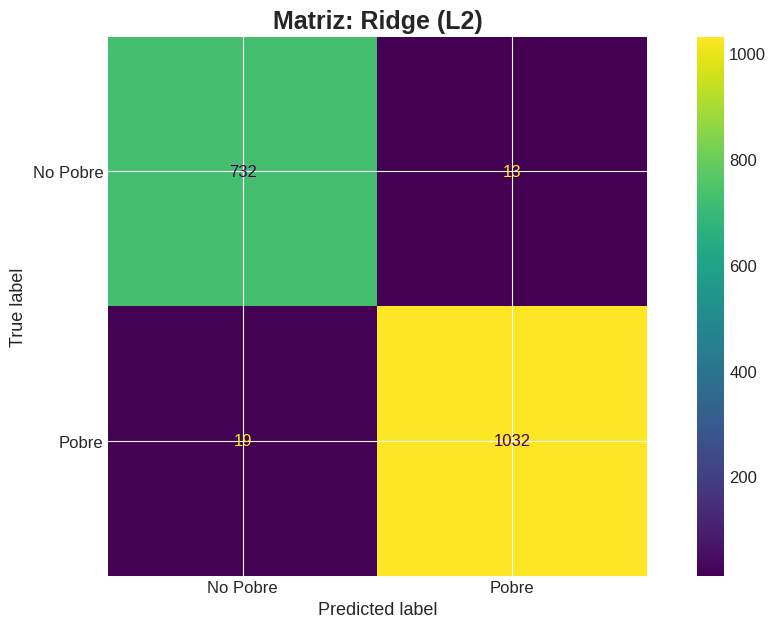


=== Matriz: CART ===


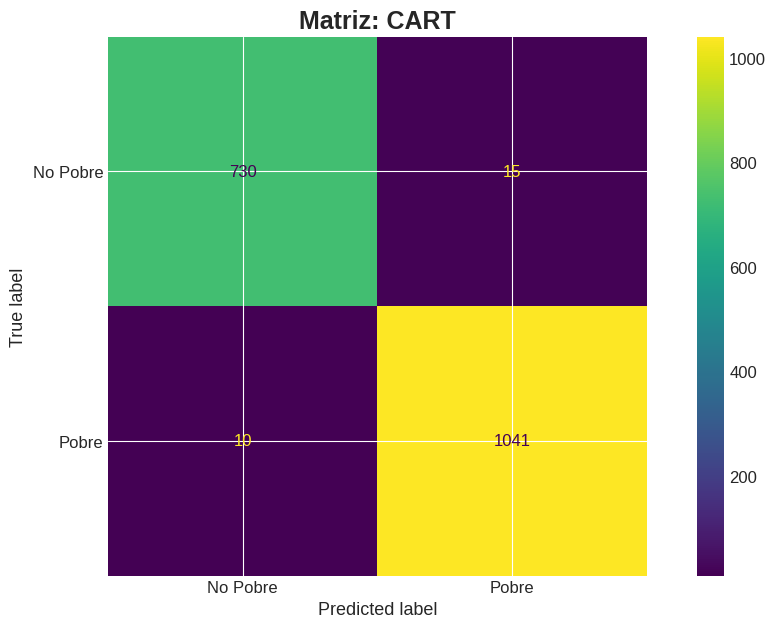


✔ Pipeline terminado. Salidas guardadas en 'graficos/' y 'salidas/'


In [29]:
# ===================================================================
# TP4: Pipeline completo (preparación, regularización LASSO/Ridge, CART,
# comparaciones, métricas y gráficos) - listo para Colab
# ===================================================================
# Requisitos: pandas, numpy, matplotlib, scikit-learn, imblearn (opcional)
# ===================================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.neighbors import KNeighborsClassifier

# Crear carpetas para salidas (no falla si ya existen)
os.makedirs("graficos", exist_ok=True)
os.makedirs("salidas", exist_ok=True)

# -------------------------
# A. CARGA Y LIMPieza INICIAL
# -------------------------
df = pd.read_csv("datos_filtrados.csv")
df.columns = df.columns.str.strip().str.lower()

# Eliminar 'horastrab' desde el origen (si existe)
if "horastrab" in df.columns:
    df = df.drop(columns=["horastrab"])
    print("✔ Eliminada columna 'horastrab' del dataset origen")

# Filtrar solo 2025 y observaciones con etiqueta de pobreza
df = df.query("año == 2025").dropna(subset=["pobre"]).copy()
print(f"Observaciones 2025: {df.shape[0]}")

# Variables predictoras según TP3 (ajustá si querés incluir otras)
features = [
    "edad",
    "edad2",
    "educ",
    "ingreso_total_familiar",
    "num_miembros_hogar"
]

# Defensive check: todas las features existen
miss = [f for f in features if f not in df.columns]
if miss:
    raise ValueError(f"Faltan columnas en el dataset: {miss}")

X = df[features].copy()
y = df["pobre"].astype(int).copy()

# Train/test split estratificado 75/25 (según tu versión)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=2025, stratify=y
)

print(f"Train: {X_train.shape[0]} | Test: {X_test.shape[0]} | % pobres train: {y_train.mean():.2%}")

# -------------------------
# Imputación (mediana) + Escalado (para modelos que lo requieran)
# -------------------------
imputer = SimpleImputer(strategy="median")
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)

scaler = StandardScaler()
X_train_sc = pd.DataFrame(scaler.fit_transform(X_train_imp), columns=features, index=X_train_imp.index)
X_test_sc  = pd.DataFrame(scaler.transform(X_test_imp), columns=features, index=X_test_imp.index)

# Para conveniencia en el notebook
X_test_sc_df = X_test_sc.copy()

# -------------------------
# B. REGULARIZACIÓN: PATH de coeficientes (LASSO y RIDGE)
# -------------------------
n_values = range(-5, 6)  # n = -5..5
lambdas = np.array([10**n for n in n_values])
Cs = 1 / lambdas

# Guardar coeficientes por C
coefs_lasso = []
coefs_ridge = []

print("Calculando trayectorias de coeficientes (LASSO y RIDGE)...")
for C_val in Cs:
    # LASSO (L1)
    # liblinear soporta L1; si falla por tamaño, usar solver='saga'
    l1 = LogisticRegression(penalty='l1', C=C_val, solver='liblinear', max_iter=5000, random_state=2025)
    l1.fit(X_train_sc, y_train)
    coefs_lasso.append(l1.coef_[0].copy())

    # RIDGE (L2)
    l2 = LogisticRegression(penalty='l2', C=C_val, solver='lbfgs', max_iter=5000, random_state=2025)
    l2.fit(X_train_sc, y_train)
    coefs_ridge.append(l2.coef_[0].copy())

coefs_lasso = np.vstack(coefs_lasso)  # shape (n_Cs, n_features)
coefs_ridge = np.vstack(coefs_ridge)

# Graficar trayectorias de coeficientes
plt.figure(figsize=(14,6))
for j, col in enumerate(features):
    plt.plot(np.log10(lambdas), coefs_lasso[:, j], label=f"{col}")
plt.xlabel("log10(lambda)")
plt.ylabel("Coeficientes")
plt.title("Trayectoria Coeficientes - LASSO (L1)")
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.grid(alpha=0.3)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.savefig("graficos/lasso_coef_path.png", dpi=200, bbox_inches='tight')
plt.show()

plt.figure(figsize=(14,6))
for j, col in enumerate(features):
    plt.plot(np.log10(lambdas), coefs_ridge[:, j], label=f"{col}")
plt.xlabel("log10(lambda)")
plt.ylabel("Coeficientes")
plt.title("Trayectoria Coeficientes - RIDGE (L2)")
plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
plt.grid(alpha=0.3)
plt.legend(loc='best', fontsize='small')
plt.tight_layout()
plt.savefig("graficos/ridge_coef_path.png", dpi=200, bbox_inches='tight')
plt.show()

# -------------------------
# C. SELECCIÓN DE LAMBDA POR CROSS-VALIDATION (LogisticRegressionCV, 5-fold)
# -------------------------
print("Buscando lambda óptimo por CV (LogisticRegressionCV, 5-fold)...")
# LogisticRegressionCV expects Cs -> array-like
Cs_for_cv = Cs

lasso_cv = LogisticRegressionCV(Cs=Cs_for_cv, cv=5, penalty='l1',
                                solver='liblinear', scoring='accuracy',
                                max_iter=5000, random_state=2025, n_jobs=-1).fit(X_train_sc, y_train)

ridge_cv = LogisticRegressionCV(Cs=Cs_for_cv, cv=5, penalty='l2',
                                solver='lbfgs', scoring='accuracy',
                                max_iter=5000, random_state=2025, n_jobs=-1).fit(X_train_sc, y_train)

best_C_lasso = lasso_cv.C_[0]
best_C_ridge = ridge_cv.C_[0]
best_lambda_lasso = 1 / best_C_lasso
best_lambda_ridge = 1 / best_C_ridge

print(f"Lambda* LASSO = {best_lambda_lasso:.6g} (C={best_C_lasso:.6g})")
print(f"Lambda* RIDGE = {best_lambda_ridge:.6g} (C={best_C_ridge:.6g})")

# Extraer error promedio por lambda a partir de scores_
def cv_error_from_lr_cv(lr_cv):
    # scores_ is a dict keyed by class_label; pick positive class '1'
    key = list(lr_cv.scores_.keys())[0]
    scores = lr_cv.scores_[key]  # shape (n_folds, n_cs)
    mean_scores = np.mean(scores, axis=0)
    return 1 - mean_scores

error_lasso = cv_error_from_lr_cv(lasso_cv)
error_ridge = cv_error_from_lr_cv(ridge_cv)

plt.figure(figsize=(10,5))
log_lambdas = np.log10(lambdas)
plt.plot(log_lambdas, error_lasso, marker='o', label='LASSO (L1)')
plt.plot(log_lambdas, error_ridge, marker='s', label='Ridge (L2)')
plt.xlabel("log10(lambda)")
plt.ylabel("Error promedio (1 - accuracy) [5-fold CV]")
plt.title("Error CV vs Penalidad (λ)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graficos/error_cv_vs_lambda.png", dpi=200, bbox_inches='tight')
plt.show()

# Opcional: proporción de coeficientes cero en LASSO por lambda
prop_zeros = (coefs_lasso == 0).mean(axis=1)
plt.figure(figsize=(8,4))
plt.plot(log_lambdas, prop_zeros, marker='o')
plt.xlabel("log10(lambda)")
plt.ylabel("Proporción coeficientes = 0")
plt.title("LASSO: Proporción de coeficientes nulos vs λ")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graficos/lasso_prop_zeros.png", dpi=200, bbox_inches='tight')
plt.show()

# -------------------------
# D. ESTIMACIÓN FINAL: Logit sin penalidad / LASSO / RIDGE con lambda^cv
# -------------------------
# 1) Logit sin penalidad
logit_none = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=5000,
    random_state=2025
)
logit_none.fit(X_train_sc, y_train)

# 2) LASSO final (usar best_C_lasso)
logit_lasso = LogisticRegression(
    penalty='l1',
    C=best_C_lasso,
    solver='liblinear',
    max_iter=5000,
    random_state=2025
)
logit_lasso.fit(X_train_sc, y_train)

# 3) RIDGE final (usar best_C_ridge)
logit_ridge = LogisticRegression(
    penalty='l2',
    C=best_C_ridge,
    solver='lbfgs',
    max_iter=5000,
    random_state=2025
)
logit_ridge.fit(X_train_sc, y_train)


# Guardar tabla de coeficientes comparativa
df_coefs = pd.DataFrame({
    "variable": features,
    "logit_none": logit_none.coef_[0],
    "lasso_cv": logit_lasso.coef_[0],
    "ridge_cv": logit_ridge.coef_[0]
})
df_coefs.to_csv("salidas/comparacion_coeficientes_tp4.csv", index=False)
display(df_coefs.round(4))

# -------------------------
# E. ÁRBOLES (CART) - Selección ccp_alpha por 10-fold CV
# -------------------------
print("GridSearchCV para ccp_alpha (10-fold CV) en CART...")
ccp_grid = {'ccp_alpha': np.linspace(0.0, 0.05, 20)}
tree = DecisionTreeClassifier(random_state=2025)
tree_cv = GridSearchCV(tree, ccp_grid, cv=10, scoring='accuracy', n_jobs=-1)
# Fit on unscaled (imputed) X (trees don't require scaling)
tree_cv.fit(X_train_imp, y_train)

# Extraer resultados y graficar error vs alpha
results_tree = pd.DataFrame(tree_cv.cv_results_)
alphas = results_tree['param_ccp_alpha'].astype(float)
mean_error = 1 - results_tree['mean_test_score'].astype(float)

plt.figure(figsize=(8,4))
plt.plot(alphas, mean_error, marker='o', drawstyle="steps-post")
plt.xlabel("ccp_alpha")
plt.ylabel("Error CV (1 - accuracy)")
plt.title("Error CV vs ccp_alpha (CART) - 10-fold")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graficos/error_vs_ccp_alpha.png", dpi=200, bbox_inches='tight')
plt.show()

best_ccp = tree_cv.best_params_['ccp_alpha']
print("Mejor ccp_alpha (CV):", best_ccp)

# Árbol final podado con el mejor alpha
tree_final = DecisionTreeClassifier(ccp_alpha=best_ccp, random_state=2025)
tree_final.fit(X_train_imp, y_train)

# Visualización del árbol (panel A)
plt.figure(figsize=(18,8))
plot_tree(tree_final, filled=True, feature_names=features, class_names=['No Pobre','Pobre'], rounded=True, fontsize=10)
plt.title(f"Árbol podado (ccp_alpha={best_ccp:.6g})")
plt.tight_layout()
plt.savefig("graficos/arbol_podado.png", dpi=200, bbox_inches='tight')
plt.show()

# Importancia (panel B)
importances = tree_final.feature_importances_
df_imp = pd.DataFrame({"variable": features, "importance": importances}).sort_values("importance", ascending=True)
plt.figure(figsize=(8,4))
plt.barh(df_imp['variable'], df_imp['importance'])
plt.xlabel("Importancia (Gini)")
plt.title("Importancia de variables - Árbol CART")
plt.tight_layout()
plt.savefig("graficos/arbol_importancias.png", dpi=200, bbox_inches='tight')
plt.show()

# -------------------------
# F. COMPARACION ENTRE MODELOS: MATRICES DE CONFUSION, ROC, METRICAS
# -------------------------
# Entrenar modelos adicionales del TP3:
# - Logit TP3: logistic con class_weight='balanced' (según tu TP3)
# - KNN TP3: KNN (k=7 por ejemplo). Si en TP3 usaste SMOTE, podés adaptar más abajo.

logit_tp3 = LogisticRegression(class_weight='balanced', solver='lbfgs', max_iter=5000, random_state=2025)
logit_tp3.fit(X_train_sc, y_train)

# KNN: elegir k (ajustalo si ya tenías otro k en TP3)
k_knn = 7
knn_tp3 = KNeighborsClassifier(n_neighbors=k_knn)
knn_tp3.fit(X_train_sc, y_train)  # Nota: en TP3 se aplicó SMOTE antes; si querés replicar exacto, aplicar SMOTE en train

# Modelos a comparar y datos de entrada correspondientes
models_info = [
    ("Logit (TP3)", logit_tp3, X_test_sc_df),
    ("KNN (TP3)", knn_tp3, X_test_sc_df),
    ("Lasso (L1)", logit_lasso, X_test_sc_df),
    ("Ridge (L2)", logit_ridge, X_test_sc_df),
    ("CART", tree_final, X_test_imp)   # árbol usa X_test_imp (no escalado)
]

# Calcular métricas y ROC
results = {}
plt.figure(figsize=(8,6))
for name, model, Xtest in models_info:
    # Probabilidades y predicciones
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(Xtest)[:,1]
    else:
        # si no hay predict_proba (raro), usar decision_function o predict
        try:
            y_proba = model.decision_function(Xtest)
        except:
            y_proba = model.predict(Xtest)

    y_pred = (y_proba > 0.5).astype(int) if y_proba.ndim == 1 else model.predict(Xtest)

    auc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fn_rate = fn / (fn + tp)

    results[name] = {"AUC": auc, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "FN_rate": fn_rate, "y_proba": y_proba, "y_pred": y_pred}

    # ROC curve plot
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],'k--', alpha=0.4)
plt.xlabel("1 - Specificity (FPR)")
plt.ylabel("Sensitivity (TPR)")
plt.title("Curvas ROC comparativas")
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("graficos/roc_comparativa.png", dpi=200, bbox_inches='tight')
plt.show()

# Guardar tabla resumen
df_results = pd.DataFrame(results).T
df_results_display = df_results[['Accuracy','Precision','Recall','F1','AUC','FN_rate']].copy()
df_results_display = df_results_display.rename(columns={'FN_rate': 'Tasa falsos negativos'})
df_results_display.to_csv("salidas/tabla_metricas_modelos_tp4.csv")
display(df_results_display.round(4))

# -------------------------
# G. MATRICES DE CONFUSIÓN (umbral 0.5) - mostrar por modelo
# -------------------------
for name, info in results.items():
    print("\n=== Matriz:", name, "===")
    cm = confusion_matrix(y_test, info["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Pobre','Pobre'])
    disp.plot(values_format='d')
    plt.title(f"Matriz: {name}")
    plt.show()

# -------------------------
# H. EXPORTAR RESULTADOS CLAVE (CSV) y guardado de objetos importantes
# -------------------------
df_results_display.to_csv("salidas/resultados_tp4_modelos_resumen.csv")
df_coefs.to_csv("salidas/coeficientes_modelos_tp4.csv", index=False)
df_imp.to_csv("salidas/importancia_arbol_tp4.csv", index=False)

print("\n✔ Pipeline terminado. Salidas guardadas en 'graficos/' y 'salidas/'")
